# Scikit-Learn

> **With great support and inspiration by** https://coursera.org/learn/vvedenie-mashinnoe-obuchenie  
it is based on open data on the internet and my own developments.
>
> Best wishes,  
**Afanasevich Vladislav**

## Contents
#### [1. Data Preparation](#Data-Preparation)
#### [2. Decomposition](#Decomposition)
#### [3. Clustering](#Clustering)
#### [4. Classical Supervised Learning](#Classical-Supervised-Learning)
#### [5. Cross-Validation](#Cross-Validation)
#### [6. Regression](#Regression)
#### [7. Classification](#Classification)
#### [8. Semi-Supervised Lerning](#Semi-Supervised-Lerning)
#### [9. Optimization](#Optimization)
#### [10. Ensemble](#Ensemble)

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import signature
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

%matplotlib inline
%pylab inline

sns.set()
pd.set_option('display.width', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# отключим предупреждения Anaconda

import warnings
warnings.filterwarnings('ignore')

In [3]:
# определим функцию, генерирующую данные, подчиняющиеся в заданном промежутке зависимости y = a*x + b + е 
# е - нормально распределено со стандартным отклонением (std) и нулевым средним

def generate_data(range_, a, b, std, num_points=100):
    
    X_train = np.random.random(num_points) * (range_[1] - range_[0]) + range_[0]
    y_train = a * X_train + b + np.random.normal(0, std, size = X_train.shape)
    
    return X_train.reshape(-1, 1), y_train

In [4]:
# определим функцию матрицы предсказаний

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Количественная матрица\nпредсказаний',
                          cmap=plt.cm.Blues):
    
    font_1 = {'family': 'normal', 'weight': 'bold', 'size': 12}
    font_2 = {'family': 'normal', 'size': 12}
    pylab.imshow(cm, interpolation='nearest', cmap=cmap)
    pylab.colorbar()
    
    tick_marks = np.arange(len(classes))
    pylab.xticks(tick_marks, classes, color='r', weight='bold')
    pylab.yticks(tick_marks, classes, color='g', weight='bold')
    
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = (cm * 100).round(2)
        title = 'Матрица предсказаний, %'
    
    thresh = cm.max() / 1.25
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pylab.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    pylab.title(title, font_1)
    pylab.ylabel('Истинные классы', font_2)
    pylab.xlabel('Прогнозируемые классы', font_2)
    pylab.grid(linestyle=' ')

In [5]:
# определим функцию графика PR-curve (для бинарной классификации)

def prc(y_true, y_score):
    
    font_1 = {'family': 'normal', 'weight': 'bold', 'size': 12}
    font_2 = {'family': 'normal', 'size': 12}
    
    average_precision = metrics.average_precision_score(y_true, y_score)
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_score)
    
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    pylab.step(recall, precision, color='b', alpha=0.2, where='post')
    pylab.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    pylab.xlabel('Recall', font_2)
    pylab.ylabel('Precision', font_2)
    pylab.ylim([0.0, 1.05])
    pylab.xlim([0.0, 1.0])
    pylab.title('PRC: Average Precision = {0:0.2f}'.format(average_precision), font_1)

In [6]:
# определим функцию графика ROC-curve (для бинарной классификации)

def roc_plot(model, X, y):
    
    font_1 = {'family': 'normal', 'weight': 'bold', 'size': 12}
    font_2 = {'family': 'normal', 'size': 12}
    
    fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(X)[:,1], pos_label=1)
    
    pylab.plot(fpr, tpr, lw=2, label='ROC curve')
    pylab.plot([0, 1], [0, 1])
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.05])
    pylab.xlabel('False Positive Rate', font_2)
    pylab.ylabel('True Positive Rate', font_2)
    pylab.title('ROC curve', font_1)

In [7]:
# определеим функцию дендрограммы

def fancy_dendrogram(*args, **kwargs):
    
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
            
    return ddata

In [8]:
# определим функцию графического отображения основных метрик для задачи регрессии

def reg_inf(X_test_scaled, y_test_scaled, 
            X_scaled, y_scaled, X, y):
    
    global real_a
    global real_b
    
    expected = y_test_scaled
    predicted = model.predict(X_test_scaled)
    
    font = {'family': 'normal', 'weight': 'bold', 'size': 12}
    
    pylab.figure(figsize=(15, 5))
    
    pylab.subplot(1, 2, 1)
    pylab.scatter(X_scaled, y_scaled, c='black')
    pylab.plot(X_scaled, X_scaled * model.coef_.round(2) + model.intercept_.round(2), c='orange')
    pylab.title('Восстановленная на стандартизированных данных зависимость', font)
    
    pylab.subplot(1, 2, 2)
    pylab.scatter(X, y, c='black')
    pylab.plot(X, real_a * X + real_b)
    pylab.title('Истинная зависимость', font)
    
    pylab.tight_layout()
    pylab.show()
    
    print('Среднеквадратичная ошибка: {:.3f}'.format(metrics.mean_squared_error(expected, predicted)))

In [9]:
# определим функцию графического отображения основных метрик для задачи классификации

def clf_inf(model, X, y):
    
    expected = y
    predicted = model.predict(X)
    
    pylab.figure(figsize=(15, 5))
    
    pylab.subplot(1, 3, 1) 
    plot_confusion_matrix(metrics.confusion_matrix(expected, predicted), classes=np.unique(y))
    
    pylab.subplot(1, 3, 2)    
    roc_plot(model, X, y)
    
    pylab.subplot(1, 3, 3)  
    prc(expected, predicted)
    
    pylab.tight_layout()
    pylab.show()
    
    print('\nAccuracy: {:.3f}, AUC-ROC: {:.3f}'.format(metrics.accuracy_score(expected, predicted), 
                                                       metrics.roc_auc_score(expected, predicted)))
    display(pd.DataFrame(metrics.classification_report(expected, predicted, output_dict=True)).T)

In [10]:
# определим функцию графика предсказаний

def bar_pred_prob(pred_prob, y):
    
    unique, freq = np.unique(y, return_counts=True)
    freq = list(map(lambda x: x / len(y), freq))
    pred_freq = pred_prob.mean(axis=0)
    
    plt.figure(figsize=(6, 5))
    font_1 = {'family': 'normal', 'weight': 'bold', 'size': 12}
    font_2 = {'family': 'normal', 'size': 12}
    
    plt.bar(range(0, 2), pred_freq, width=0.1, align="edge", label='Прогнозируемые классы')
    plt.bar(range(0, 2), freq, width=-0.1, align="edge", label='Истинные классы')
    
    plt.xlabel('Номер класса', font_2)
    plt.ylabel('Соотношение долей', font_2)
    plt.title('График предсказаний', font_1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(pred_freq.round(2))

In [11]:
# определим функцию AUC-score (для бинарной классификации)

def auc(model, y_train, X_train, y_test, X_test): 
    return '[AUC-ROC] train: {:.2f}, [AUC-ROC] test: {:.3f}'.format(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                            metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

def auc_lgbm(model, y_train, X_train, y_test, X_test): 
    return '[AUC-ROC] train: {:.2f}, [AUC-ROC] test: {:.3f}'.format(metrics.roc_auc_score(y_train, model.predict(X_train)),
                            metrics.roc_auc_score(y_test, model.predict(X_test)))

# Data Preparation

## Regression Sample

In [12]:
# зададим параметры для генерации искусственных данных
real_a, real_b, real_std = 0.34, 13.7, 7

# сгенерируем данные для промежутка от 0 до 150 с заданными выше параметрами
Xr, yr = generate_data([0, 150], real_a, real_b, real_std)

# выведем табличку с полученными данными
data = pd.DataFrame({'X': Xr.flatten(), 'Y': yr})
data.head()

,X,Y
0,26.538243,17.402944
1,105.655318,62.981881
2,109.923187,40.465653
3,35.581551,15.747911
4,124.047106,47.340969


In [13]:
# отобразим основные статистические параметры данных
data.describe()

,X,Y
count,100.000000,100.000000
mean,69.407437,36.783179
std,42.239399,15.838953
min,3.114923,7.401186
25%,29.491437,23.157763
50%,64.252909,35.843945
75%,103.166373,48.363803
max,148.486791,73.666565


Большинство градиентных методов (на которых по факту и основаны почти все алгоритмы машинного обучения) сильно чуствительны к шкалированию данных. Поэтому перед запуском самих алгоритмов чаще всего делается **масштабирование** (**нормализация** или **стандартизация**) данных, и это касается не только задач регрессии.

In [14]:
Xrn = preprocessing.normalize(Xr) # признаки X меняются так, чтобы каждый из них лежал в диапазоне от 0 до 1 (нормализация)
Xrs = preprocessing.scale(Xr) # признаки X меняются так, что их среднее = 0, а дисперсия = 1 (стандартизация)

yrs = preprocessing.scale(yr)

In [15]:
# разделим выборку на обучающую и тестовую (без нормализации и стандартизации признаков и целевой переменной)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

# разделим выборку на обучающую и тестовую (со стандартизацией признаков и целевой переменной)
Xrs_train, Xrs_test, yrs_train, yrs_test = train_test_split(Xrs, yrs, test_size=0.2, random_state=42)

# разделим выборку на обучающую и тестовую (с нормализацией признаков)
Xrn_train, Xrn_test, yr_train, yr_test = train_test_split(Xrn, yr, test_size=0.2, random_state=42)

## Classification Sample

In [16]:
dataset = pd.read_csv('C:/Users/Unknown Soldier/Desktop/Workspace/AI/Datasets/pima-indians-diabetes.csv')

print(dataset.shape)
dataset.head(15)

(767, 9)


,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
5,3,78,50,32,88,31.0,0.248,26,1
6,10,115,0,0,0,35.3,0.134,29,0
7,2,197,70,45,543,30.5,0.158,53,1
8,8,125,96,0,0,0.0,0.232,54,1
9,4,110,92,0,0,37.6,0.191,30,0


In [17]:
dataset.describe()

,6,148,72,35,0,33.6,0.627,50,1
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


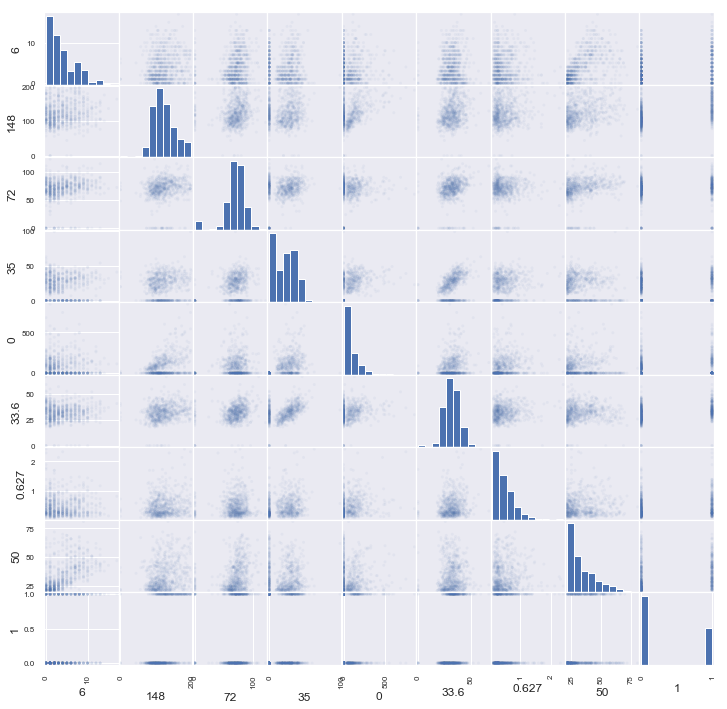

In [18]:
from pandas.tools.plotting import scatter_matrix

# построим гистограммы и диаграммы рассеивания для всех столбцов
scatter_matrix(dataset, alpha=0.05, figsize=(12, 12));

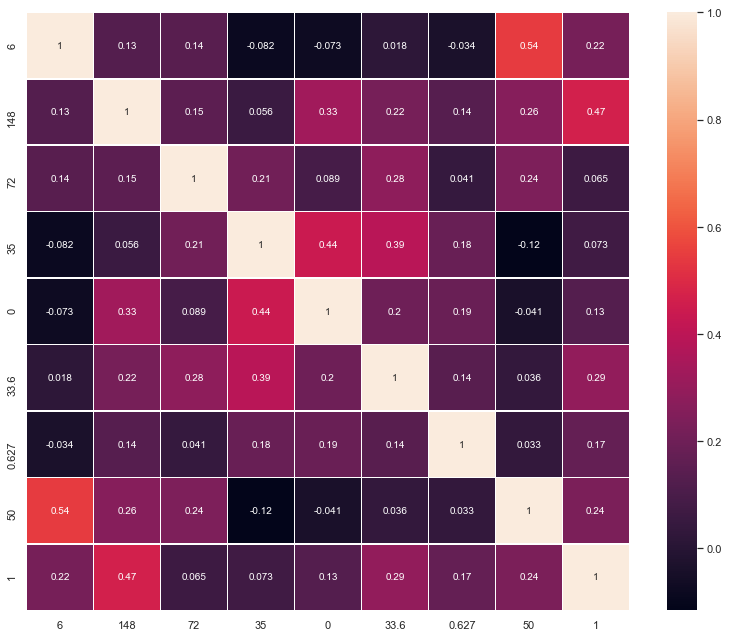

In [19]:
# проверим наличие корреляций между значениями всех объектов и признаков

fig, ax = plt.subplots(figsize=(13.5, 11))
sns.heatmap(dataset.corr(), annot=True, linewidths=.5, ax=ax);

In [20]:
# выделим значения меток класса в переменную y, а признаковые описания в переменную X
# так как данные числовые и не имеют пропусков, переведем их в numpy-формат с помощью метода .values
yc = dataset[dataset.columns[-1]].values
Xc = dataset[dataset.columns[:-1]].values

print(Xc.shape, yc.shape)

(767, 8) (767,)


In [21]:
Xcn = preprocessing.normalize(Xc)
Xcs = preprocessing.scale(Xc)

ycs = preprocessing.scale(yc)

In [22]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

Xcs_train, Xcs_test, ycs_train, ycs_test = train_test_split(Xcs, ycs, test_size=0.2, random_state=42)

Xcn_train, Xcn_test, yc_train, yc_test = train_test_split(Xcn, yc, test_size=0.2, random_state=42)

## Feature Selection

> https://habr.com/ru/post/264915/

Зачастую самым важным при решении задачи является умение правильно **отобрать или создать признаки**. В англоязычной литературе это называется **Feature Selection** или, соответственно, **Feature Engineering**. В то время как создание признаков довольно творческий процесс и полагается больше на интуицию и экспертные знания, для отбора есть уже большое количество готовых алгоритмов.

Почему отбор признаков вообще необходим? Основных причин две:

1) Если признаков очень много – увеличивается время работы классификатора. Если стоит цель протестировать несколько классификаторов для выбора лучшего, то время, необходимое на вычисления, может стать просто огромным. Кроме того, данные могут перестать помещаться в оперативную память, тогда придется модифицировать алгоритмы классификаторов. Может перестать помещаться даже одна строка датасета, хотя это уже редкий случай.

2) Главная причина – с увеличением количества признаков часто падает точность предсказания. Особенно если в данных много мусорных признаков (мало коррелирующих с целевой переменной). Это явление также называют переобучением.

Итак, все методы отбора признаков делятся на три категории: методы фильтрации (**filter methods**), методы-обертки (**wrapper methods**) и встроенные методы (**embedded methods**).

В большинстве случаев проще и удобнее всего будет обратиться к встроенным методам. Однако, в случае, если нужна наглядность – методы фильтрации помогут ее обеспечить. Остальное – вопрос практики.

### Filter Methods

**Методы фильтрации** основаны на статистических методах и, как правило, рассматривают каждый признак независимо. Они позволяют оценить и ранжировать признаки по значимости, за которую принимаются степени корреляции признаков с целевой переменной.

Ниша методов фильтрации – случаи, когда тренировать модель на всем объеме признаков мы просто не можем – памяти не хватает. Тогда другие методы не сработают.

Чем этот класс методов хорош? У них низкая стоимость вычислений, которая линейно зависит от общего количества признаков. Они значительно быстрее и оберток, и встроенных методов. К тому же они хорошо работают даже тогда, когда число признаков у нас превышает количество примеров в тренировочном сете (чем далеко не всегда могут похвастаться методы других категорий).

В чем их недостатки? Они рассматривают каждый признак изолированно, из-за чего найти  топ$-n$ наиболее коррелирующих признаков вообще говоря не означает получить подмножество, на котором точность предсказаний будет наивысшей.

**Information Gain**

Чем больше **степень информативности** – тем сильнее корреляция. Таким образом, мы легко можем вычислить  для всех признаков и выкинуть те, которые слабо влияют на целевую переменную. Так, во-первых, сокращаем время расчета модели, а, во-вторых, уменьшаем риск переобучения.

In [23]:
from sklearn.feature_selection import mutual_info_classif

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Correlation': mutual_info_classif(Xc, yc, discrete_features=True).round(2)})
df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
6,0.627,0.45
5,33.6,0.24
1,148,0.21
4,0,0.19
7,50,0.10
3,35,0.06
0,6,0.04
2,72,0.04


**Chi-square**

Метод **хи-квадрат** определяет ожидаемую вероятность наступления одновременно обоих событий, если мы предполагаем, что они независимы, а затем вычисляет, насколько реальность отличается от наших ожиданий. Его формула выглядит так:
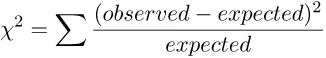

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Chi2K = SelectKBest(chi2, k=3)
X_new = Chi2K.fit_transform(Xc, yc)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Necessity': Chi2K.get_support(), 'Score': Chi2K.scores_.round(2)})
df.sort_values(by='Score', ascending=False)

,Feature,Necessity,Score
4,0,True,2219.40
1,148,True,1406.59
7,50,True,178.01
5,33.6,False,127.67
0,6,False,110.73
3,35,False,51.01
2,72,False,17.50
6,0.627,False,5.36


**mRmR**

Данный метод учитывает не только корреляцию между признаками и целевой переменной, но так же избыточность признаков (его полное название – **минимальная избыточность при максимальной релевантности**). Метод пытается максимизировать следующее выражение:

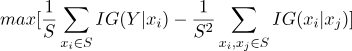

Здесь первое слагаемое отвечает за максимизацию корреляции между выбранным набором признаков $S$ и целевой переменной $Y$ (аналогично методу $IG$), а второе – за минимизацию корреляций между признаками. Таким образом, полученный набор признаков не только релевантен, но и признаки в этом наборе минимально повторяют друг друга. В этом методе признаки добавляются  в набор по одной с выбором оптимального на каждом шаге.

### Wrapper Methods

**Методы-обертки** отличаются от остальных тем, что классификатор запускается на разных подмножествах признаков исходного тренировочного сета. Затем выбирается подмножество признаков с наилучшими параметрами на обучающей выборке. И наконец он тестируется на тестовом сете (с условием, что тестовый сет не участвует в процессе выбора оптимального подмножества).

В этом классе методов есть два подхода – методы включения (**forward selection**) и исключения (**backward selection**) признаков. Первые стартуют с пустого подмножества, куда постепенно добавляются разные признаки (для выбора на каждом шаге оптимального добавления). Во втором случае метод стартует с подмножества равного исходному множеству признаков, и из него постепенно удаляются признаки с пересчетом классификатора каждый раз.

Несмотря на то, что методы данной группы лучше отслеживают взаимосвязи между признаками, они гораздо дороже вычислительно, чем методы фильтрации. К тому же в случае большого количества признаков и небольшого размера тренировочного сета эти методы имеют опасность переобучения.

**RFE (backward selection)**

Как следует из расшифровки названия, метод относится к алгоритмам **постепенного исключения признаков** из общего пула. Кроме того, он требует выбрать классификатор, с помощью которого признаки будут оцениваться – например, линейная регрессия. Несмотря на то, что данный метод отлично отслеживает взаимосвязи между признаками, следует всегда помнить, что он требует очень много ресурсов для их вычисления.

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

rfe = RFE(LinearRegression(), 5)
rfe = rfe.fit(Xc, yc)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Necessity': rfe.support_, 'Priority': rfe.ranking_})
df.sort_values(by='Priority')

,Feature,Necessity,Priority
0,6,True,1
1,148,True,1
5,33.6,True,1
6,0.627,True,1
7,50,True,1
2,72,False,2
4,0,False,3
3,35,False,4


**Extra Trees (forward selection)**

Одна из особенностей **решающих деревьев** заключается в том, что они позволяют получать важности всех используемых признаков. Важность признака можно оценить на основе того, как сильно улучшился критерий качества благодаря использованию этого признака в вершинах дерева.

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

ExtraTrees = ExtraTreesClassifier()
ExtraTrees.fit(Xc, yc)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Correlation': ExtraTrees.feature_importances_.round(2)})
df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,148,0.26
5,33.6,0.15
7,50,0.14
6,0.627,0.12
0,6,0.10
2,72,0.09
3,35,0.08
4,0,0.07


### Embedded Methods

**Встроенные методы** позволяют не разделять отбор признаков и обучение классификатора, а производят отбор внутри процесса расчета модели. К тому же, эти алгоритмы требуют меньше вычислений, чем обертки (хотя и больше, чем фильтрации).

Отличительной особенностью в этой категории является **регуляризация**. Существуют различные ее разновидности, но основной принцип общий. Например, если алгоритм классификации – линейная регрессия, то подбираются коэффициенты полинома, который аппроксимирует зависимость между признаками и целевой переменной. В качестве оценки качества подобранных коэффициентов может выступать, например, **среднеквадратичная ошибка**. Параметры подбираются так, чтобы суммарное отклонение (точнее суммарный квадрат отклонений) у точек предсказанных классификатором от реальных точек было минимальным. Идея регуляризации в том, чтобы построить алгоритм минимизирующий не только ошибку, но и количество используемых переменных.

Если рассмотреть работу классификатора без регуляризации, то она состоит в построении такой модели, которая наилучшим образом настроилась бы на предсказание всех точек тренировочного сета.

**Ridge Regression**

Если в тестовом сете дана матрица признаков $A$ и вектор целевой переменной $b$, то мы ищем решение в виде $Ax=b$. В процессе работы алгоритма минимизируется такое выражение:



Здесь первое слагаемое – это как раз среднеквадратичная ошибка, а второе – регуляризирующий оператор (сумма квадратов всех коэффициентов, умноженная на $\alpha$). В процессе работы алгоритма размеры коэффициентов будут пропорциональны важности соответствующих переменных, а перед теми переменными, которые дают наименьший вклад в устранение ошибки, станут околонулевые. 

Пара слов о параметре $\alpha$: он позволяет настраивать вклад регуляризирующего оператора в общую сумму. С его помощью мы можем указать приоритет – точность модели или минимальное количество используемых переменных.

In [27]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(Xcs_train, ycs_train)
ycs_train_pred = ridge.predict(Xcs_train)
ycs_test_pred = ridge.predict(Xcs_test)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Correlation': ridge.coef_.round(3)})
print(df, '\n')

print('[MSE] train: {:.3f}, test: {:.3f}'.format(
        metrics.mean_squared_error(ycs_train, ycs_train_pred),
        metrics.mean_squared_error(ycs_test, ycs_test_pred)))

print('[R^2] train: {:.3f}, test: {:.3f}'.format(
        metrics.r2_score(ycs_train, ycs_train_pred),
        metrics.r2_score(ycs_test, ycs_test_pred)))

  Feature  Correlation
0       6        0.137
1     148        0.393
2      72       -0.056
3      35        0.005
4       0       -0.010
5    33.6        0.197
6   0.627        0.099
7      50        0.067 

[MSE] train: 0.708, test: 0.670
[R^2] train: 0.287, test: 0.348


**Lasso Regression**

Аналогичен предыдущему во всем кроме отличия в регуляризирующем операторе. Он представляет собой не сумму квадратов, а сумму модулей коэффициентов. Несмотря на незначительность различия, свойства отличаются.

Если в случае с **Ridge** по мере роста альфа все признаки получают коэффициенты их полезности все ближе к нулевым, но обычно при этом все-таки не зануляются, то в **Lasso** с ростом альфа все больше коэффициентов становятся нулевыми и совсем перестают вносить свой вклад в модель. Так мы получаем действительно хороший отбор признаков. Более значимые признаки сохранят свои коэффициенты ненулевыми, менее значимые – обнулятся.

In [28]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(Xcs_train, ycs_train)
ycs_train_pred = lasso.predict(Xcs_train)
ycs_test_pred = lasso.predict(Xcs_test)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Correlation': lasso.coef_.round(3)})
print(df, '\n')

print('[MSE] train: {:.3f}, test: {:.3f}'.format(
        metrics.mean_squared_error(ycs_train, ycs_train_pred),
        metrics.mean_squared_error(ycs_test, ycs_test_pred)))

print('[R^2] train: {:.3f}, test: {:.3f}'.format(
        metrics.r2_score(ycs_train, ycs_train_pred),
        metrics.r2_score(ycs_test, ycs_test_pred)))

  Feature  Correlation
0       6        0.071
1     148        0.327
2      72        0.000
3      35        0.000
4       0        0.000
5    33.6        0.107
6   0.627        0.020
7      50        0.010 

[MSE] train: 0.742, test: 0.731
[R^2] train: 0.252, test: 0.288


**Elastic Net**

Также используется комбинация **Ridge** и **Lasoo** регрессии, которая и получила название **Elastic Net** (она не так агрессивно отбирает признаки). То есть, если есть группа признаков, каждый из которых информативен, но все они линейно зависимы – в таком случае **Elastic Net** оставляет всю группу признаков и вместе им понижает веса, а не оставляет, например, только один из этих признаков.

In [29]:
from sklearn.linear_model import ElasticNet

ElaNet = ElasticNet(alpha=0.1)
ElaNet.fit(Xcs_train, ycs_train)
ycs_train_pred = ElaNet.predict(Xcs_train)
ycs_test_pred = ElaNet.predict(Xcs_test)

df = pd.DataFrame({'Feature': np.array(dataset.columns[:-1]), 'Correlation': ElaNet.coef_.round(3)})
print(df, '\n')

print('[MSE] train: {:.3f}, test: {:.3f}'.format(
        metrics.mean_squared_error(ycs_train, ycs_train_pred),
        metrics.mean_squared_error(ycs_test, ycs_test_pred)))

print('[R^2] train: {:.3f}, test: {:.3f}'.format(
        metrics.r2_score(ycs_train, ycs_train_pred),
        metrics.r2_score(ycs_test, ycs_test_pred)))

  Feature  Correlation
0       6        0.098
1     148        0.338
2      72       -0.000
3      35        0.000
4       0        0.000
5    33.6        0.140
6   0.627        0.060
7      50        0.038 

[MSE] train: 0.721, test: 0.708
[R^2] train: 0.274, test: 0.311


Таким образом, **регуляризация** – это своеобразный штраф за излишнюю сложность модели, который позволяет защитить себя от перетренировки в случае наличия среди признаков мусорных (когда независимые переменные коррелируют друг с другом, т.е. имеет место мультиколлинеарность). Не стоит думать, что регуляризация бывает только в линейных моделях – и для бустинга, и для нейросетей существуют свои методы регуляризации.

Из минусов регуляризации можно отметить тот факт, что модель строится на всем массиве признаков а значит, она не ускоряет работу классификатора. Но в общем случае этот метод способен лучше уловить взаимозависимости переменных, чем методы фильтрации. 

## Feature Engeneering

> https://habr.com/ru/company/mlclass/blog/248129/

Наверное, самый известный и понятный пример создания новых признаков есть в курсе Andrew Ng. Пример заключается в следующем: с помощью линейных моделей прогнозируется цена дома в зависимости от множества признаков, среди которых есть такие, как длина дома и ширина. Линейная регрессия в данном случае прогнозирует цену дома, как линейную комбинацию ширины и длины. Но ведь любому здравому человеку понятно, что цена дома в первую очередь зависит от площади дома, которая никак не выражается через линейную комбинацию длины и ширины. Поэтому, качество алгоритма существенным образом увеличивается, если длину и ширину заметить на их произведение. Тем самым, мы получим новый признак, который наиболее сильно влияет на цену дома, а также сокращаем размерность признакового пространства. Это, пожалуй, самый простой и наглядный пример создания признаков. Заметим, что очень сложно придумать метод, который для любой наперед заданной задачи давал бы технику построения признаков. Тем не менее, существует ряд достаточно простых методов и техник.

### Categorical Features

Допустим, у наших обьектов есть признаки, которые принимают значения на конечном наборе. Например, цвет (**color**), который может быть синим (**blue**), красным (**red**), зеленым (**green**), или его значение может быть неизвестно (**unknown**). В таком случае бывает полезным добавлять признаки вида **is_red**, **is_blue**, **is_green**, **is_red_or_blue** и другие возможные комбинации.

### Date and Time

Если среди признаков есть дата или время – как правило, очень часто помогает добавлять такие признаки, как **время дня**, **количество прошеднего времени с определенного момента**, **выделение сезонов, времен года или кварталов**. Также помогает **разделение времени на часы, минуты и секунды** (если время дано в Unix-Time или ISO формате). Вариантов в данном месте масса, каждый из которых подбирается под конкретну задачу.

### Numeric Features

Если переменная вещественная, часто помогает ее **округление или разделение на целую и вещественную часть (с последующей нормализацией)**. Или же, часто помогает **приведение числового признака в категориальный**. Например, если есть такой признак как масса, то можно ввести признаки вида «масса больше $X$», «масса от $X$ до $Y$».

### String Features

Если есть признак, значением которого является конечное количество строк – стоит не забывать, что в самих строках зачастую содержится информация. Наглядным примером является задача **Titanic: Machine Learning from Disaster**, в которой имена участников плавания имели приставки **«Mr.»**, **«Mrs.»** и **«Miss.»**, по которым легко извлечь половой признак.

### Other Algorithms Results

Часто в качестве признака также можно добавить результат работы других алгоритмов. Например, если решается задача классификации, можно сначала **решить вспомогательную задачу кластеризации**, и **в первоначальной задаче взять кластер обьекта в качестве признака**. Это обычно происходит на основе первичного анализа данных **в случае, когда обьекты хорошо кластеризуются**.

### Aggregated Features

Имеет также смысл добавлять признаки, которые агрегируют признаки некоторого обьекта, следствием чего является **сокращение размерности признакового описания**. Как правило, это полезно в задачах, в которых один обьект содержит несколько однотипных параметров. Например, человек, имеющий несколько автомобилей разной стоимости. В данном случае можно рассмотреть признаки, соответствующие максимальной/минимальной/средней стоимости автомобиля этого человека.

### Created Features

Этот пункт скорее надо отнести больше к практическим задачам из реальной жизни, нежели к соревнованиям по машинному обучению. **Данная группа требует отдельного рассмотрения**. Однако стоит отметить, что зачастую, чтобы эффективно решить задачу, необходимо быть экспертом в конкретной области и понимать, что влияет на конкретную целевую переменную. Возвращаясь к примеру с ценой квартиры – каждый знает, что цена зависит в первую очередь от площади, однако, в более сложной предметной области такие заключения делать достаточно сложно.

# Decomposition

### PCA (Dimension Reduction)

**Метод главных компонент** используется, когда имеется множество исходных числовых признаков и нужно перейти в пространство новых числовых признаков, но желательно сделать так, чтобы их оказалось меньше, а также чтобы новые признаки содержали всю основную информацию о старых. Это требование можно формализовать, например, так, что старые признаки должны восстанавливаться по новым. При этом новые признаки строятся так, чтобы сохранить как можно больше дисперсии в данных. Иными словами, метод главных компонент **понижает размерность данных** оптимальным с точки зрения сохранения дисперсии способом. То есть, несмотря на то, что новых признаков меньше – значение старых на всех объектах обучающей выборки, тем не менее, можно восстановить. Можно наложить то или иное ограничение на класс преобразований, с помощью которых старые признаки восстанавливаются по новым. Метод главных компонент – это частный случай, когда мы предполагаем, что это **преобразование линейно**. На эту тему можно изобрести и другие обобщения, пользуясь нелинейными преобразованиями (например, **t-SNE**), но пока рассмотрим только линейную модель.

Основным параметром метода главных компонент является количество новых признаков. Как и в большинстве методов машинного обучения, нет четких рекомендаций по поводу выбора значения этого параметров. Один из подходов – выбирать минимальное число компонент, при котором объясняется не менее определенной доли дисперсии (это означает, что в выборке сохраняется данная доля от исходной дисперсии).

Этот прием часто **используется в анализе данных для сжатия и визуализации данных** не только для решения задачи регрессии, но и для классификации. Кромет того, он используется и в обработке изображений.

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(Xc)

m1 = pca.fit_transform(Xc)
m2 = np.dot(pca.components_, (Xc - pca.mean_).transpose())

i = 2

if np.linalg.norm(m2 - m1.transpose()) < 1e-10:
    print('Матрицы m1 и m2 идентичны.')
    
print('Размер матрицы долей влияния каждой компоненты на каждый признак:', pca.components_.shape[0], '*', 
     pca.components_.shape[1])
print('Доли влияния компонент на целевую переменную:', pca.explained_variance_ratio_.round(3))
print('Доля дисперсии, которая объясняется числом компонент, равным ', i, ': ', np.sum(pca.explained_variance_ratio_[0:i]).round(3), sep='')

Xc_pca = pd.DataFrame(pca.transform(Xc))
Xc_pca.head()

Матрицы m1 и m2 идентичны.
Размер матрицы долей влияния каждой компоненты на каждый признак: 4 * 8
Доли влияния компонент на целевую переменную: [0.889 0.062 0.026 0.013]
Доля дисперсии, которая объясняется числом компонент, равным 2: 0.95


,0,1,2,3
0,-82.463229,28.854877,-5.482990,8.993247
1,-74.712889,-68.000953,19.395949,-5.533207
2,10.968114,34.849377,-0.042954,1.328045
3,89.647521,-2.758712,25.225220,18.957712
4,-81.078342,-4.040393,0.608439,-15.049703


In [31]:
a = Xc_pca[1].corr(dataset['1']) # a = np.corrcoef(Xc_pca[1], dataset['1'])[0, 1]

print('Корреляция между элементамы второй компоненты и меток класса:')
print('{0:.2f}'.format(a))

dataset.columns[np.argmax(pca.components_[1])]

Корреляция между элементамы второй компоненты и меток класса:
-0.45


'0'

# Clustering

> https://proglib.io/p/unsupervised-ml-with-python/

**Кластеризация** – это отдельный класс задач машинного обучения, отличающийся от классификации тем, что у объектов обучающей выборки нет заранее заданных ответов учителя, поэтому данный метод основан на идеи самостоятельного поиска шаблонов в наборе данных.

Наша задача – используя все имеющиеся данные, определить классы и предсказать соответствие объектов выборки их истинным классам, сформировав таким образом кластеры.

## Hierarchical Clustering

**Иерархическая кластеризация** – это специальная разновидность методов кластеризации, которая позволяет обойти тонкий момент с определением числа кластеров.

Иерархическая кластеризация, как следует из названия, представляет собой алгоритм, который строит иерархию кластеров. Этот алгоритм начинает работу с того, что каждому экземпляру данных сопоставляется свой собственный кластер. Затем два ближайших кластера объединяются в один и так далее, пока не будет образован один общий кластер. Таким образом, в случае иерархической кластеризации необходимо вычислять расстояния между кластерами.

Результат иерархической кластеризации может быть наглядно представлен с помощью **дендрограммы**.


**Рекомендации:**
* Использование расстоянием Уорда $R^y$
* Построение нескольких вариантов дендрограммы и выбор лучшей визуально

In [32]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dataset_dist = pdist(Xcs, 'euclidean') # вычислим расстояния между всеми объектами датасета
dataset_linkage = linkage(dataset_dist, method='complete') # объединим элементы в кластеры

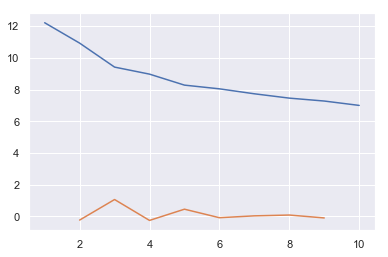

Рекомендуемое количество кластеров:  3


In [33]:
# Метод локтя (показывает сумму внутри групповых вариаций и позволяет оценить оптимальное количество кластеров)

last = dataset_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

plt.figure(figsize=(6.2, 4))
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]

plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()

k = acceleration_rev.argmax() + 2 
print("Рекомендуемое количество кластеров: ", k)

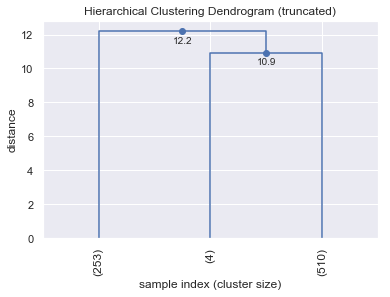

In [34]:
plt.figure(figsize=(6, 4))
fancy_dendrogram(
    dataset_linkage,
    truncate_mode='lastp',
    p=int(k), 
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.show()

In [35]:
from scipy.cluster.hierarchy import fcluster

# clusters = fcluster(dataset_linkage, 300, criterion='distance')
clusters = fcluster(dataset_linkage, int(k)-1, criterion='maxclust')

expected = yc
predicted = clusters - 1

print('Точность иерархической кластеризации на датасете с известными объектами:\n', 
      metrics.accuracy_score(expected, predicted).round(2))

Точность иерархической кластеризации на датасете с известными объектами:
 0.59


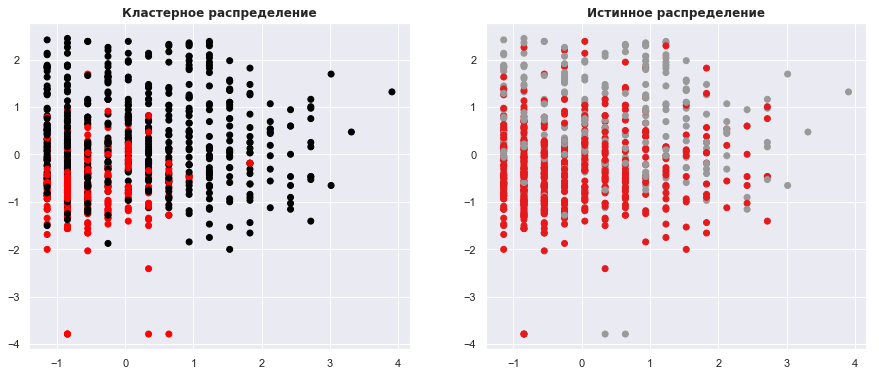

In [36]:
font = {'family': 'normal', 'weight': 'bold', 'size': 12}

pylab.figure(figsize=(15, 6))

pylab.subplot(1, 2, 1)
pylab.scatter(Xcs[:,0], Xcs[:,1], c=clusters, cmap='flag')
pylab.title('Кластерное распределение', font)

pylab.subplot(1, 2, 2)
pylab.scatter(Xcs[:,0], Xcs[:,1], c=yc, cmap='Set1')
pylab.title('Истинное распределение', font)

pylab.show()

**Результат кластеризации** – это одномерный массив с номерами класстеров к которым относятся строки оригинальных данных. Для удобства обработки совместим оригинальные данные и номера кластеров.

In [37]:
dataset_I = dataset
dataset_I['_1'] = clusters - 1
dataset_I.head()

,6,148,72,35,0,33.6,0.627,50,1,_1
0,1,85,66,29,0,26.6,0.351,31,0,0
1,8,183,64,0,0,23.3,0.672,32,1,1
2,1,89,66,23,94,28.1,0.167,21,0,0
3,0,137,40,35,168,43.1,2.288,33,1,1
4,5,116,74,0,0,25.6,0.201,30,0,0


### K-Means

Наиболее простым и популярным алгоритмом кластеризации данных является метод **К-средних**. Это итеративный алгоритм кластеризации, основанный на минимизации суммарных квадратичных отклонений точек кластеров от их центроидов – средних координат этих кластеров.

Первоначально выбирается желаемое количество кластеров. Затем для каждого кластера ставится в соответствие элемент – случайно определенный центроид. Далее алгоритм ищет ближайшего соседа текущего центроида, добавляет точку к соответствующему кластеру и пересчитывает положение центроида с учетом координат новых точек.  Алгоритм заканчивает работу, когда координаты каждого центроида перестают меняться. Центроид каждого кластера в результате представляет собой набор значений признаков, описывающих усредненные параметры выделенных классов.

При выводе данных нужно понимать, что алгоритм не знает ничего о нумерации классов, а определенные им числа – это лишь номера кластеров, определенных в результате работы алгоритма. Так как исходные точки выбираются случайным образом, вывод будет несколько меняться от одного запуска к другому.

**Недостатки:**
* Чувствительность к выбору начального приближения
* Необходимость заранее задавать число кластеров

**Способы устранения недостатков:**
* Применение различных эвристик для выбора начального приближения (например, мультистарт)
* Применение методов мягкой кластеризации
* Применение более быстрых алгоритмов (k-means++, сэмплирование)
* Варьирование числа кластеров в ходе итераций

In [38]:
from sklearn.cluster import KMeans

km = KMeans(init='k-means++', n_clusters=2, random_state=42)
km.fit(Xcs)

expected = yc
predicted = km.labels_

print('Точность кластеризации методом К-средних на датасете с известными объектами:\n', 
      metrics.accuracy_score(expected, predicted).round(2))

Точность кластеризации методом К-средних на датасете с известными объектами:
 0.67


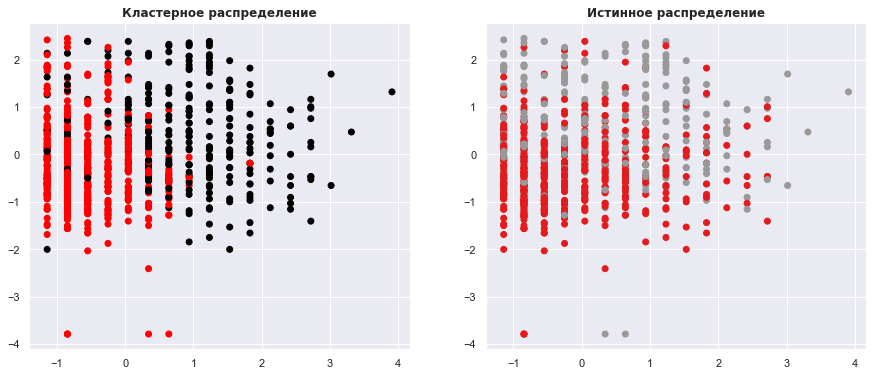

In [39]:
font = {'family': 'normal', 'weight': 'bold', 'size': 12}

pylab.figure(figsize=(15, 6))

pylab.subplot(1, 2, 1)
pylab.scatter(Xcs[:,0], Xcs[:,1], c=km.labels_, cmap='flag')
pylab.title('Кластерное распределение', font)

pylab.subplot(1, 2, 2)
pylab.scatter(Xcs[:,0], Xcs[:,1], c=yc, cmap='Set1')
pylab.title('Истинное распределение', font)

pylab.show()

In [40]:
dataset_K = dataset
dataset_K['_1'] = km.labels_
dataset_K.head()

,6,148,72,35,0,33.6,0.627,50,1,_1
0,1,85,66,29,0,26.6,0.351,31,0,0
1,8,183,64,0,0,23.3,0.672,32,1,1
2,1,89,66,23,94,28.1,0.167,21,0,0
3,0,137,40,35,168,43.1,2.288,33,1,0
4,5,116,74,0,0,25.6,0.201,30,0,0


# Classical Supervised Learning

Все модели машинного обучения используют тот или иной метод как идею. Ниже приведены возможные методы, на основе которых реализованы практически все модели машинного обучения.

## Logical Methods

**Логические методы** строятся на основе объединения определенного количества простых решающих правил, благодаря чему итоговый алгоритм является интерпретируемым (логичным).

## Metric Methods

**Метрические методы** основаны на гипотезе компактности, суть которой состоит в том, что объекты с похожими признаковыми описаниями имеют похожие значения целевой переменной. Если эта гипотеза верна, то строить прогноз для нового объекта можно на основе близких к нему объектов из обучающей выборки – например, путем усреднения их ответов (для регрессии) или путем выбора наиболее популярного среди них класса (для классификации). Методы такого типа и называются метрическими. Они имеют несколько особенностей:

* Процедура обучения, по сути, отсутствует – достаточно лишь запомнить все объекты обучающей выборки
* Можно использовать метрику, учитывающую особенности конкретного набора данных – например, наличие категориальных признаков
* При правильном выборе метрики и достаточном размере обучающей выборки метрические алгоритмы показывают качество, близкое к оптимальному

Метрические методы чувствительны к масштабу признаков – так, если масштаб одного из признаков существенно превосходит масштабы остальных признаков, то их значения практически не будут влиять на ответы алгоритма. Поэтому важно производить масштабирование признаков (обычно помогает стандартизация).

## Linear Methods

**Линейные методы** – распространенный класс моделей, которые отличается своей простотой и скоростью работы. Их можно обучать за разумное время на очень больших объемах данных, и при этом они могут работать с любыми типами признаков – вещественными, категориальными, разреженными.

Как и в случае с метрическими методами, качество линейных алгоритмов зависит от некоторых свойств данных. В частности, признаки должны быть нормализованы (стандартизированы), то есть иметь одинаковый масштаб. Если это не так, и масштаб одного признака сильно превосходит масштаб других – качество может резко упасть.

Линейные методы имеют несколько очень важных подвидов. Так, например, метод опорных векторов максимизирует отступы объектов, что тесно связано с минимизацией вероятности переобучения. При этом он позволяет очень легко перейти к построению нелинейной разделяющей поверхности благодаря ядерному переходу. А логистическая регрессия позволяет оценивать вероятности принадлежености классам, что оказывается полезным во многих прикладных задачах.

### Gradient Descent

> https://neurohive.io/ru/osnovy-data-science/gradient-descent/

**Градиентный спуск** – самый используемый алгоритм обучения. Градиентный спуск – это, по сути, и есть тот инструмент, с помощью которого обучаются модели.

Возможно 2 основных подхода к реализации градиентного спуска:

* Пакетный (**batch**), когда на каждой итерации обучающая выборка просматривается целиком. Это требует больших вычислительных затрат.
* Стохастический (**stochastic / online**), когда на каждой итерации алгоритма из обучающей выборки случайным образом выбирается один объект.

Задача градиентного спуска заключается в поиске минимального значения функции потерь (**loss function**). Существует множество разновидностей этой функции, минимизация любой из которых означает поиск самой глубокой впадины данной функции. Она используется, чтобы контролировать ошибку в прогнозах модели машинного обучения (определять, насколько высока точность проделанной работы алгоритма). Поиск минимума означает получение наименьшей возможной ошибки или повышение точности модели. Мы увеличиваем точность, перебирая набор учебных данных при настройке таких параметров модели, как веса и смещения (**weights** и **bias**).

Итак, градиентный спуск нужен для минимизации функции потерь. Цель – получить наименьшее значение ошибки. Аналогично это можно рассматривать как спуск во впадину в попытке найти золото (самое низкое значение ошибки) на дне ущелья (глобальный минимум функции).

В дальнейшем, чтобы найти самую низкую ошибку (глубочайшую впадину) в функции потерь (по отношению к одному весу), нужно настроить параметры модели. В этом помогает математический анализ, благодаря которому мы знаем, что наклон графика функции есть производная от данной функции по переменной. Этот наклон всегда указывает на ближайшую впадину.

**Важно:** когда мы перебираем все учебные данные, мы продолжаем добавлять значения для каждого веса. Так как потери зависят от примера обучения, значения для каждого веса также продолжают меняться. Затем все собранные значения делятся на количество примеров обучения для получения среднего значения. Наконец, мы используем это среднее значение (каждого веса) для настройки каждого веса.

Функция потерь предназначена для отслеживания ошибки с каждым примером обучениям, в то время как производная функции относительного одного веса – это то, куда нужно сместить вес, чтобы минимизировать ее для этого примера обучения. Можно создавать модели даже без применения функции потерь, но тогда придется использовать и производную относительно каждого веса.

Теперь, когда мы определили направление, в котором нужно подтолкнуть вес, нам нужно понять, как это сделать. Тут мы используем коэффициент скорости обучения (**learning rate / alpha**), его называют гиперпараметром. Обычно значения гиперпараметров могут быть изучены методом проб и ошибок. Однако, что касается коэффициента скорости обучения, его можно рассматривать как «шаг в правильном направлении».

Здесь мы рассмотрели функцию потерь, построенную на один вес. В реальной модели мы делаем всё перечисленное выше для всех весов, перебирая все примеры обучения. Даже в относительно небольшой модели машинного обучения будет более, чем 1 или 2 веса. Это затрудняет визуальное представление работы алгоритма, поскольку график будет обладать размерами, которые разум не может себе представить.

# Cross-Validation

Технически **кросс-валидация** проводится в два этапа:

1. Создается генератор разбиений **KFold**, который задает набор разбиений на обучение и валидацию. Число блоков в кросс-валидации определяется параметром **n_splits**. Следует заметить, что порядок следования объектов в выборке может быть неслучайным, это может привести к смещенности кросс-валидационной оценки. Чтобы устранить такой эффект, объекты выборки случайно перемешивают перед разбиением на блоки. Для перемешивания достаточно передать генератору параметр **shuffle**=True.

2. При помощи функции **cross_val_score** вычисляется качество на всех разбиениях, куда качестве параметра **estimator** передается классификатор, а в качестве параметра **cv** – генератор разбиений с предыдущего шага. С помощью параметра **scoring** можно задавать меру качества – по умолчанию в задачах классификации используется доля верных ответов (**accuracy**). Результатом является массив, значения которого нужно усреднить.

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cross_validation(model, X, y, loss_func):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X, y, cv=kf, scoring=loss_func, n_jobs=-1)
    print('\nKFold ' + loss_func + ' results: {} with mean: {:.3f}'.format(cv_results.round(3), cv_results.mean()))

# Regression

## SGD Regressor

Проверка гиперпараметров модели:
 SGDRegressor(alpha=0.05, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=10000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


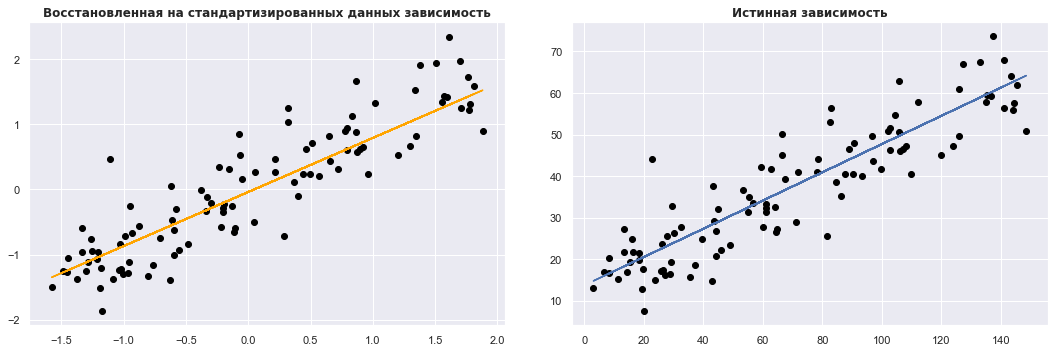

Среднеквадратичная ошибка: 0.243

KFold neg_mean_squared_error results: [-0.243 -0.113 -0.109 -0.339 -0.242] with mean: -0.209


In [42]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha=0.05, max_iter=10000, random_state=42) # применим алгоритм SGD регрессии
model.fit(Xrs_train, yrs_train) # запустим тренировку на подготовленных данных
print('Проверка гиперпараметров модели:\n', model)

reg_inf(Xrs_test, yrs_test, Xrs, yrs, Xr, yr) # изобразим графически информацию о работе

cross_validation(model, Xrs, yrs, 'neg_mean_squared_error') # запустим тренировку на кросс-валидации

## Linear Regression

**Многомерная линейная регрессия** – это классический алгоритм не только для машинного обучения, но и для прикладной статистики. Принцип, на котором строится линейная регрессия – **метод наименьших квадратов**, в статистические свойства которого мы здесь вдаваться не будем. Линейная регрессия вычисляет оценочные функции коэффициентов регрессии или просто прогнозируемые веса для всех измерений, которые и определяют конечную функцию аппроксимации. Эта функция захватывает зависимости между входами и выходом достаточно хорошо.

Проблема мультиколлинеарности, которая приводит к плохой обусловленности, неустойчивости и переобучению преследует линейные модели повсюду, но с ним можно справиться с помощью некоторых модификаций, речь о которых пойдет далее.

Проверка гиперпараметров модели:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


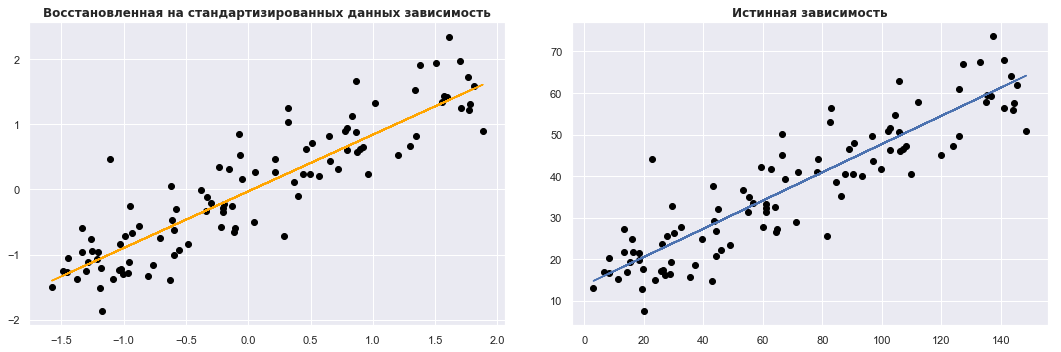

Среднеквадратичная ошибка: 0.226

KFold neg_mean_squared_error results: [-0.226 -0.106 -0.111 -0.371 -0.224] with mean: -0.208


In [43]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1) # применим алгоритм линейной регрессии
model.fit(Xrs_train, yrs_train) # запустим тренировку на подготовленных данных
print('Проверка гиперпараметров модели:\n', model)

reg_inf(Xrs_test, yrs_test, Xrs, yrs, Xr, yr) # изобразим графически информацию о работе

cross_validation(model, Xrs, yrs, 'neg_mean_squared_error') # запустим тренировку на кросс-валидации

Помимо "сырой" линейной регресси часто используют **Lasso** или **Ridge** регрессию. Они отличаются только типом штрафа за большие веса: учитывать **модули** (**Lasso**) или **квадраты** весов (**Ridge**).

Учитывая, что мы выбрали среднеквадратичную ошибку (**MSE**) как функцию потерь, то в случае **Ridge**-регресси будет: 

$$Loss = MSE = \sum (pred_i-y_i)^2 + \alpha*\sum W_i^2$$  

А в случае **Lasso**-регресси будет: 

$$Loss = MSE = \sum (pred_i-y_i)^2 + \alpha*\sum |W_i|$$  

Здесь $\alpha$ - заранее задаваемый гиперпараметр. Это вес, с которым второе слагаемое будет влиять на функцию потерь.

**Гребневая регрессия** и **Лассо** – это два метода, которые позволяют задать вектор коэффициентов линейной модели так, чтобы у нас не проявлялась проблема мультиколлиниарности. При этом **Лассо** обладает дополнительным интересным свойством обнулять некоторые веса признаков, тем самым выбрасывая такие признаки из модели. Оба метода имеют параметр регуляризации, который можно также называть параметром селективности, потому как варьируя этот параметр в методе **Лассо** мы можем исключать больше или меньше признаков из модели.

### Ridge Regression

Проверка гиперпараметров модели:
 Ridge(alpha=0.04, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)


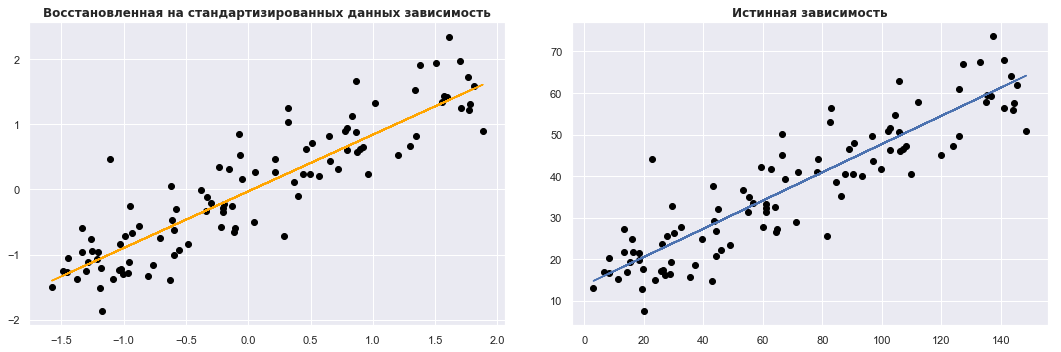

Среднеквадратичная ошибка: 0.226

KFold neg_mean_squared_error results: [-0.226 -0.106 -0.111 -0.37  -0.224] with mean: -0.208


In [44]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.04, random_state=42) # применим алгоритм Ridge регрессии
model.fit(Xrs_train, yrs_train) # запустим тренировку на подготовленных данных
print('Проверка гиперпараметров модели:\n', model)

reg_inf(Xrs_test, yrs_test, Xrs, yrs, Xr, yr) # изобразим графически информацию о работе

cross_validation(model, Xrs, yrs, 'neg_mean_squared_error') # запустим тренировку на кросс-валидации

### Lasso Regression

Проверка гиперпараметров модели:
 Lasso(alpha=0.04, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)


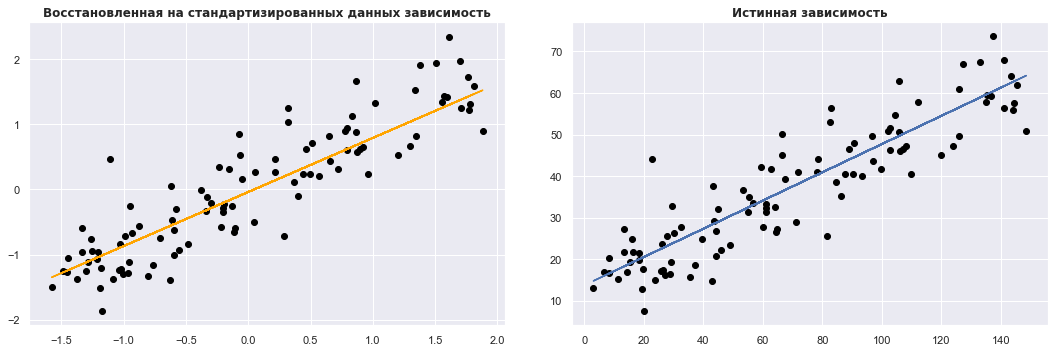

Среднеквадратичная ошибка: 0.242

KFold neg_mean_squared_error results: [-0.242 -0.113 -0.109 -0.343 -0.241] with mean: -0.210


In [45]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.04, random_state=42) # применим алгоритм Lasso регрессии
model.fit(Xrs_train, yrs_train) # запустим тренировку на подготовленных данных
print('Проверка гиперпараметров модели:\n', model)

reg_inf(Xrs_test, yrs_test, Xrs, yrs, Xr, yr) # изобразим графически информацию о работе

cross_validation(model, Xrs, yrs, 'neg_mean_squared_error') # запустим тренировку на кросс-валидации

### ElasticNet Regression

Проверка гиперпараметров модели:
 ElasticNet(alpha=0.04, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)


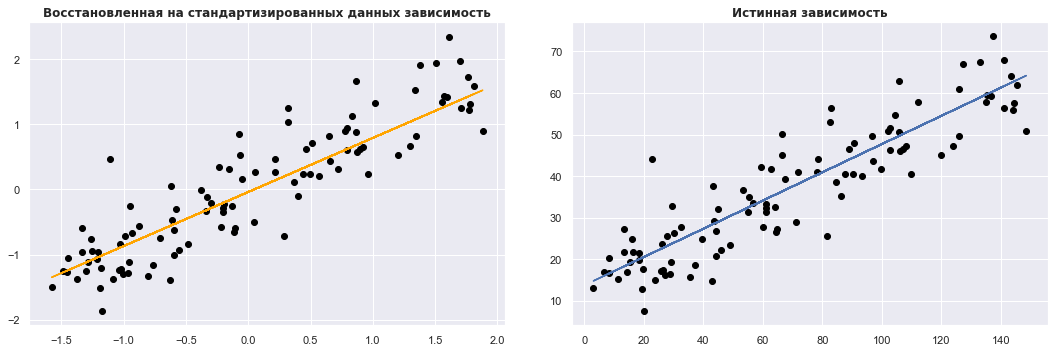

Среднеквадратичная ошибка: 0.241

KFold neg_mean_squared_error results: [-0.241 -0.112 -0.109 -0.344 -0.239] with mean: -0.209


In [46]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(0.04, random_state=42) # применим алгоритм Elastic Net регрессии
model.fit(Xrs_train, yrs_train) # запустим тренировку на подготовленных данных
print('Проверка гиперпараметров модели:\n', model)

reg_inf(Xrs_test, yrs_test, Xrs, yrs, Xr, yr) # изобразим графически информацию о работе

cross_validation(model, Xrs, yrs, 'neg_mean_squared_error') # запустим тренировку на кросс-валидации

# Classification

## SGD Classifier

Проверка гиперпараметров модели:
 SGDClassifier(alpha=0.05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.01,
       validation_fraction=0.1, verbose=0, warm_start=False)


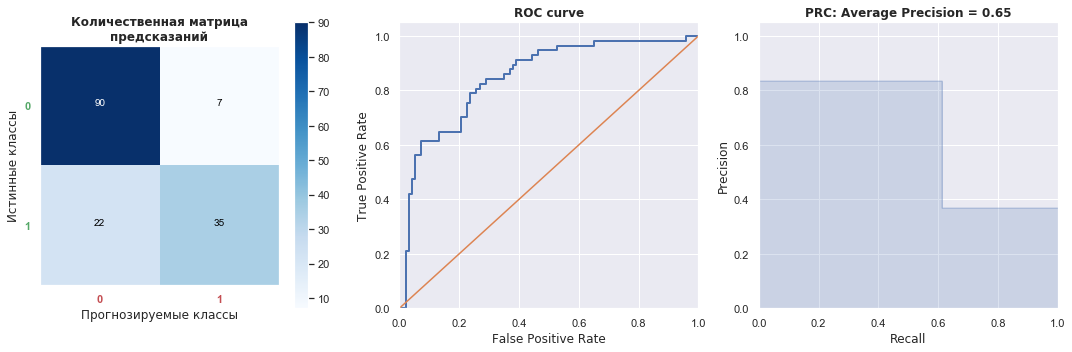


Accuracy: 0.812, AUC-ROC: 0.771


,f1-score,precision,recall,support
0,0.861244,0.803571,0.927835,97.0
1,0.707071,0.833333,0.614035,57.0
micro avg,0.811688,0.811688,0.811688,154.0
macro avg,0.784157,0.818452,0.770935,154.0
weighted avg,0.804180,0.814587,0.811688,154.0


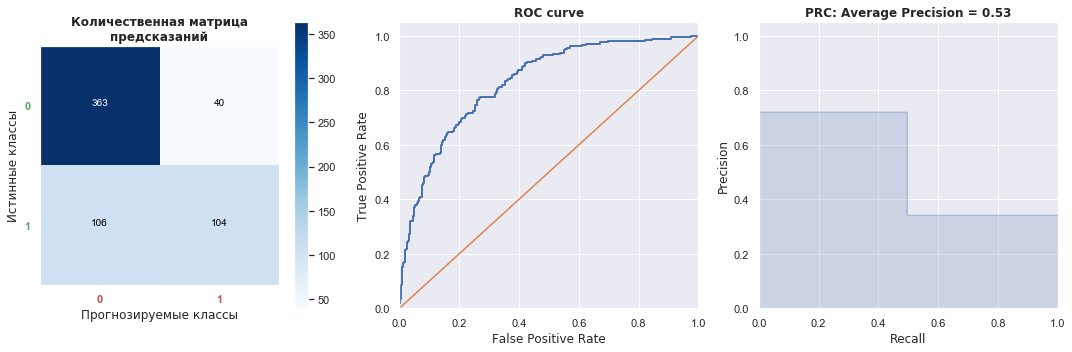


Accuracy: 0.762, AUC-ROC: 0.698


,f1-score,precision,recall,support
0,0.832569,0.773987,0.900744,403.0
1,0.587571,0.722222,0.495238,210.0
micro avg,0.761827,0.761827,0.761827,613.0
macro avg,0.710070,0.748105,0.697991,613.0
weighted avg,0.748638,0.756254,0.761827,613.0



KFold accuracy results: [0.805 0.721 0.817 0.706 0.765] with mean: 0.763


In [47]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log', alpha=0.05, max_iter=10000, tol=1e-2, random_state=42) # применим алгоритм SGD классификатора
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе (НА ТЕСТОВОЙ ВЫБОРКЕ)
clf_inf(model, Xcs_train, yc_train) # изобразим графически информацию о работе (НА ТРЕНИРОВОЧНОЙ ВЫБОРКЕ)

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

## Logistic Regression

> https://habr.com/ru/company/io/blog/265007/

**Логистическая регрессия** – один из видов линейных классификаторов. Одной из ее особенностей является возможность оценивания вероятностей классов, тогда как большинство линейных классификаторов могут выдавать только сами классы и их номера. Чаще всего используется для решения задач бинарной классификации, но допускается и многоклассовая (так называемый **one-vs-all** метод).

Логистическая регрессия использует достаточно сложный функционал качества, который не допускает записи решения в явном виде (в отличие от, например, линейной регрессии). Тем не менее, логистическую регрессию можно настраивать с помощью градиентного спуска.

Основная идея логистической регрессии заключается в том, что пространство исходных значений может быть линейно разделено. В случае двух измерений – это простая прямая линия без изгибов. В случае трех – плоскость, и так далее. Эта граница задается в зависимости от имеющихся исходных данных и обучающего алгоритма. Чтобы все работало, точки исходных данных должны разделяться линейной границей на две области – если точки исходных данных удовлетворяют этому требованию, то их можно назвать линейно разделимыми.

Стоит отметить, что логистическая регрессия часто используется вместе с регуляризацией.

Проверка гиперпараметров модели:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


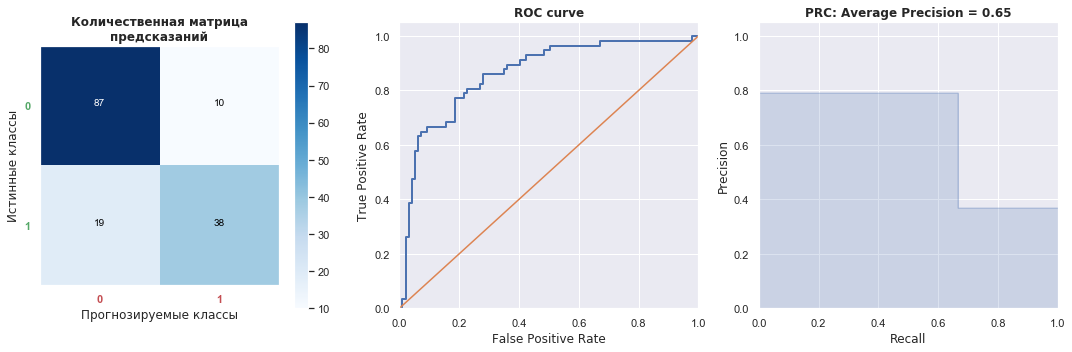


Accuracy: 0.812, AUC-ROC: 0.782


,f1-score,precision,recall,support
0,0.857143,0.820755,0.896907,97.0
1,0.723810,0.791667,0.666667,57.0
micro avg,0.811688,0.811688,0.811688,154.0
macro avg,0.790476,0.806211,0.781787,154.0
weighted avg,0.807792,0.809988,0.811688,154.0



KFold accuracy results: [0.812 0.747 0.83  0.725 0.784] with mean: 0.780


In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42) # применим алгоритм логистической регрессии
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

## Здесь и далее:

> https://habr.com/ru/company/ods/blog/328372/

> https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/

Когда мы хотим измерить качество алгоритма классификации, первое, что можно сделать – посчитать, на скольки объектах мы даем правильный ответ, и поделить полученное количество на размер выборки. Это метрика так и называется – доля правильных ответов (**accuracy**). Она очень интуитивная, но у нее есть проблемы с интерпретацией на несбалансированных выборках. В случаях, когда разные ошибки имеют разную цену, гораздо лучше измерять две другие метрики качества вместо одной: точность (**precision**) и полноту (**recall**).

У доли правильных ответов есть и другие проблемы, но прежде, чем говорить о них, разберемся с тем, какие виды ошибок вообще может допускать классификатор. Каждый объект характеризуется двумя числами – его истинный класс и предсказание алгоритма. В зависимости от сочетания этих двух чисел, можно разделить все объекты на четыре категории. Первая – верные срабатывания (**True Positive**) – к ним относятся те объекты, на которых истинный класс – 1, и алгоритм возвращает 1. Если же объект относится к классу 0, но алгоритм относит его к классу 1 – это ложное срабатывание (**False Positive**) – **ошибка I-го рода**.  
И, наоборот, если объект относится к классу 1, а алгоритм относит в 0 – это ложный пропуск (**False Negative**) – **ошибка II-го рода**. Если же объект относится к классу 0, и мы относим его к классу 0 – это верный пропуск (**True Negative**).  
Через эти четыре показателя можно выразить и долю правильных ответов. Она равна отношению числа верных ответов в нашей выборке, то есть сумме верных срабатываний и верных пропусков, к размеру всей выборки, то есть сумме всех четырех показателей.

Точность (**precision**) показывает, насколько мы можем доверять классификатору, если он выдает ответ 1. Более формально она равна отношению числа верных срабатываний к количеству объектов, на которых алгоритм выдал ответ 1.
Полнота (**recall**) показывает, как много объектов класса 1 наш алгоритм находит. Более формально она равна отношению числа верных срабатываний к общему размеру класса 1.

Таким образом, **precision** можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а **recall** показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. **Чем выше точность – тем меньше ложных срабатываний. Чем выше полнота – тем меньше ложных пропусков.** В зависимости от того, какие ошибки мы меньше хотим допускать, мы можем отдавать предпочтения либо точности, либо полноте.  
В разных задачах эти предпочтения могут быть разные. Именно введение **precision** не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня **False Positive**. **Recall** демонстрирует способность алгоритма обнаруживать данный класс вообще, а **precision** – способность отличать этот класс от других классов.  
**Precision** и **recall** не зависят, в отличие от **accuracy**, от соотношения классов и потому применимы в условиях несбалансированных выборок. Часто в реальной практике стоит задача найти оптимальный (для заказчика) баланс между этими двумя метриками.

Классическим примером является задача определения оттока клиентов. Очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по **precision** и **recall**. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах колл-центра.

Обычно при оптимизации гиперпараметров алгоритма (например, в случае перебора по сетке **GridSearchCV**) используется одна метрика, улучшение которой мы и ожидаем увидеть на тестовой выборке. Точность и полнота – очень неплохие метрики. Но при этом их две. Как их объединить? Первое, что приходит в голову – это найти арифметическое среднее. Однако, это далеко не самый лучший вариант. Существует несколько различных способов объединить **precision** и **recall** в агрегированный критерий качества. Самый универсальный из них – **$F-$мера** (в общем случае $\ F_\beta$) – **среднее гармоническое precision и recall**.  
Чтобы посчитать это, нужно найти отношение произведения точности и полноты к их сумме и умножить это на 2. **$F-$мера** достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

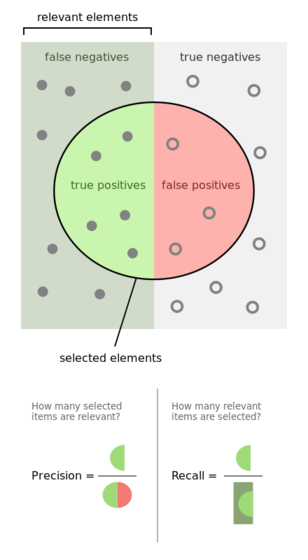

**Support** в таблице метрик отображает количество экземпляров каждого класса.

В некоторых задачах гораздо полезнее работать с оценкой принадлежности объектов к одному из классов, чем с бинарными ответами классификатора. В этом случае измерение качества основывается на площадях под кривыми (**ROC-кривой** или **PR-кривой**).

При конвертации вещественного ответа алгоритма (как правило, вероятности принадлежности к классу, **отдельно см. SVM**) в бинарную метку, мы должны выбрать какой-либо порог, при котором для ответа 0 становится 1. Естественным и близким кажется порог, равный 0.5, но он не всегда оказывается оптимальным, например, при отсутствии баланса классов (которые превалируют в реальной практике, и часто приходится прибегать к техникам искусственной модификации датасета для выравнивания соотношения классов).

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является **AUC-ROC** – площадь (**Area Under Curve**) под кривой ошибок (**Receiver Operating Characteristic**). Данная кривая представляет из себя линию от (0, 0) до (1, 1) в координатах **True Positive Rate** (**TPR**) и **False Positive Rate** (**FPR**):

$\large TPR = \frac{TP}{TP + FN}$

$\large FPR = \frac{FP}{FP + TN}$

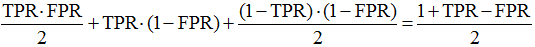

**TPR** – это полнота, а **FPR** показывает, какую долю из объектов negative класса алгоритм предсказал неверно. В идеальном случае, когда классификатор не делает ошибок ($FPR = 0$, $TPR = 1$) мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, **AUC-ROC** будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество **TP** и **FP**.

Критерий **AUC-ROC** устойчив к несбалансированным классам и может быть интерпретирован как вероятность того, что случайно выбранный **positive** объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть **positive**), чем случайно выбранный **negative** объект.

Также площадь под **ROC-кривой** имеет много интересных интерпретаций. Например, она равна вероятности того, что случайно взятый объект класса один получит оценку принадлежности к классу один выше, чем случайно взятый объект класса ноль. Благодаря таким интерпретациям эту метрику можно легко объяснить заказчикам. Но при этом у нее есть свои недостатки. В частности имеются существенные проблемы при сильном дисбалансе классов.

**Precision Recall Curve** зависит от двух других характеристик – точности и полноты. При этом точность нормируется не на размер одного из классов, а на количество объектов, которые классификатор отнес к первому классу. Из-за этого точность зависит от соотношения классов. Если одного из классов выборки станет больше, то и точность может измениться. Еще одна особенность **PR-кривой** в том, что максимальная площадь под ней зависит от свойств выборки. В том время, как у **ROC-кривой** она всегда равная единице, в то же время **PR-кривая** гораздо лучше ведет себя, если имеет место сильный дисбаланс классов.

### Принципы решения задач многоклассовой классификации через бинарную

Разумеется, существуют отдельные подходы для того, чтобы сразу строить многоклассовые алгоритмы классификации. Однако, можно свести задачу многоклассовой классификации и к задаче бинарной классификации. 

**One-vs-all**

Первый подход называется **один против всех**. Идея состоит в том, чтобы построить несколько классификаторов, каждый из которых будет отделять один класс от всех остальных. 

Возьмём класс $n$. Для него обучающей выборкой будет служить полная выборка, а ответы будут бинарные: 1 – если объект относится к классу $n$, 0 – если относится к одному из других классов. То есть для этой задачи нужно построить классификатор, который будет давать оценку принадлежности объекта к классу 1. Бинарные ответы здесь не подойдут, нам нужны вещественные числа. Дальше, когда мы построили необходимое число таких бинарных классификаторов, построить итоговый алгоритм очень просто. Мы вычисляем эти вещественные оценки принадлежности, находим максимальную из них, и именно этот класс возвращаем в качестве ответа.

**All-vs-all**

Другая идея называется **каждый против каждого**. Здесь мы будем строить свой классификатор для каждой пары классов. Их количество будет квадратичное от числа классов. Итак, возьмём пару классов $k$ и $m$. Обучающей выборкой для них будет служить подмножество исходной выборки, то есть объекты, которые относятся либо к классу $k$, либо к классу $m$. Это будут не все объекты. Ответы будут бинарные: 1 – если объект относится к классу $k$, и 0 – если он относится к классу $m$. Нужно снова построить оценку принадлежности объекта к классу $k$ – вещественное число. При этом должно выполняться свойство симметрии: если алгоритм даёт определённую оценку принадлежности к классу $k$ в паре $k$ и $m$, то в паре $m$ и $k$ оценка должна быть такой же, но с противоположным знаком. Итоговый алгоритм для каждого класса вычисляет суммарную оценку принадлежности к нему против всех остальных классов и выдаёт тот класс, для которого эта оценка получается максимальной.

**Сравнение**

Подход «один против всех» строит линейное от количества классов число классификаторов. При этом каждый из классификаторов обучается на полной выборке. Здесь могут возникнуть проблемы с несбалансированными выборками. Например, если классов много, то бинарная задача будет иметь небольшое число примеров положительного класса и большое число примеров отрицательного. Некоторые алгоритмы классификации плохо работают в этих случаях. 

В случае подхода «каждый против каждого», число классификаторов квадратичное. При этом каждый из них обучается на небольшой подвыборке. Поэтому если сложность алгоритма, например, экспоненциально зависит от размера выборки, то подход «каждый против каждого» будет гораздо удобнее.

**Как обобщить на случай многоклассовой классификации точность, полноту, площадь под ROC/PR кривыми и другие?** 

Для этого нужно рассмотреть определенное количество задач бинарной классификации, каждая из которых отделяет один из классов от всех остальных. Здесь есть два подхода. 

Первый называется **микро‐усреднение**. В нём сначала для каждой задачи бинарной классификации вычисляются базовые показатели: число верных срабатываний, ложных срабатываний, ложных пропусков и верных пропусков. Дальше эти показатели усредняются по всем задачам. И уже по усреднённым показателям вычисляется итоговая метрика, например точность. В этом случае вклад каждого класса в результат зависит от его размера, поскольку мы усредняем базовые показатели.

Второй подход называется **макро‐усреднение**. В этом случае, мы вычисляем итоговую метрику, например точность, для каждой из бинарных задач. И дальше усредняем по задачам значение этой метрики. В таком случае все классы будут вносить равный вклад.

**Микро‐усреднение** учитывает наиболее крупные классы при подсчёте результата. **Макро‐усреднение** учитывает все классы с одинаковым весом, без учёта их размеров, из чего также следует, что оно дает гораздо более маленький результат относительно микро-усреднения.

## Naive Bayes

> http://datareview.info/article/6-prostyih-shagov-dlya-osvoeniya-naivnogo-bayesovskogo-algoritma-s-primerom-koda-na-python/

**Наивный байесовский алгоритм** – это вероятностный алгоритм классификации, основанный на теореме Байеса с допущением о независимости признаков. Другими словами, НБА предполагает, что наличие какого-либо признака в классе не связано с наличием какого-либо другого признака. Например, фрукт может считаться яблоком, если он красный, круглый и его диаметр составляет порядка 8 сантиметров. Даже если эти признаки зависят друг от друга или от других признаков, в любом случае они вносят независимый вклад в вероятность того, что этот фрукт является яблоком. В связи с таким допущением алгоритм и называется наивным.

Модели на основе НБА достаточно просты и крайне полезны при работе с очень большими наборами данных. При своей простоте НБА способен превзойти даже некоторые сложные алгоритмы классификации. Основной задачей данного алгоритма является восстановление плотностей распределения данных обучающей выборки. Зачастую этот метод дает хорошее качество в задачах именно многоклассовой классификации.

**Преимущества:**
* Легкая и быстрая классификация (в том числе многоклассовая)
* Когда допущение о независимости выполняется, НБА превосходит другие алгоритмы, такие как, например, логистическая регрессия, и при этом требует меньший объем обучающих данных
* Лучше работает с категориальными признаками, чем с непрерывными

**Недостатки:**
* Если в тестовом наборе данных присутствует некоторое значение категориального признака, которое не встречалось в обучающем наборе данных, то модель присвоит нулевую вероятность этому значению и не сможет сделать верный прогноз. Это явление известно под названием «нулевая частота» (**Zero Frequency**)
* Не следует доверять найденным результатам вероятностей принадлежности объектов к классам
* Допускает независимость признаков, но в реальности наборы полностью независимых признаков встречаются крайне редко

**Способы устранения недостатков:**
* Проблему нулевой частоты можно решить с помощью сглаживания – например, по Лапласу (**Laplace Smoothing**)

Проверка гиперпараметров модели:
 GaussianNB(priors=None, var_smoothing=1e-09)


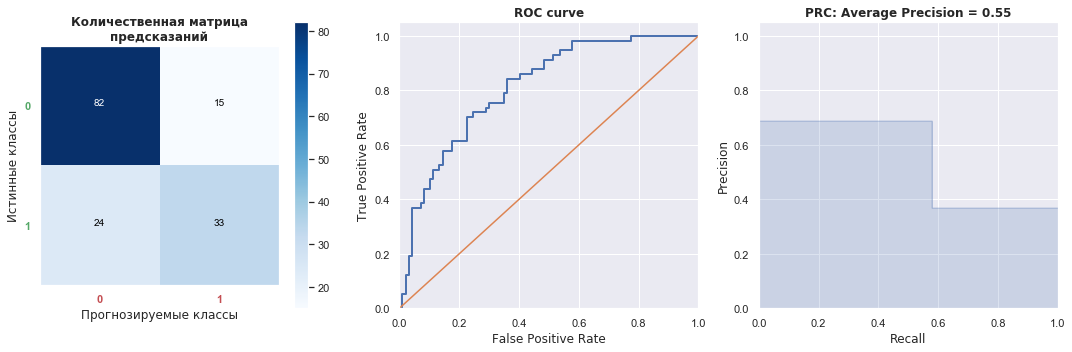


Accuracy: 0.747, AUC-ROC: 0.712


,f1-score,precision,recall,support
0,0.807882,0.773585,0.845361,97.0
1,0.628571,0.687500,0.578947,57.0
micro avg,0.746753,0.746753,0.746753,154.0
macro avg,0.718227,0.730542,0.712154,154.0
weighted avg,0.741514,0.741722,0.746753,154.0



KFold accuracy results: [0.747 0.708 0.784 0.745 0.778] with mean: 0.752


In [49]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB() # применим алгоритм Наивного Байеса
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

## K-NN

> https://habr.com/ru/post/149693/

**К-ближайших соседей** относится к метрическим методам. Для определенеия ответа на каждом объекте тестовой выборки необходимо последовательно вычислить расстояние до каждого из объектов обучающей выборки и отобрать $k$ объектов обучающей выборки, расстояние до которых минимально, затем просто обозначить класс классифицируемого объекта также, как класс наиболее часто встречающийся среди К-ближайших соседей.

Часто данный метод используется как составная часть более сложного алгоритма классификации. Например, его оценку можно использовать как признак для обьекта. А иногда, простой K-NN на хорошо подобранных признаках сам по себе дает отличное качество. Зачастую при грамотной настройке параметров (в основном – метрики) алгоритм дает хорошее качество и в задачах регрессии.

**Преимущества:**
* Устойчив к аномальным выбросам
* Прост в реализации
* Легко интерпретируется
* Гибкая модификация

**Недостатки:**
* Выборка данных должна представлять все основные особенности генеральной совокупности (то есть быть репрезентативной)
* Модель нельзя отделить от данных: для классификации нового примера нужно использовать все примеры обучающей выборки

Проверка гиперпараметров модели:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


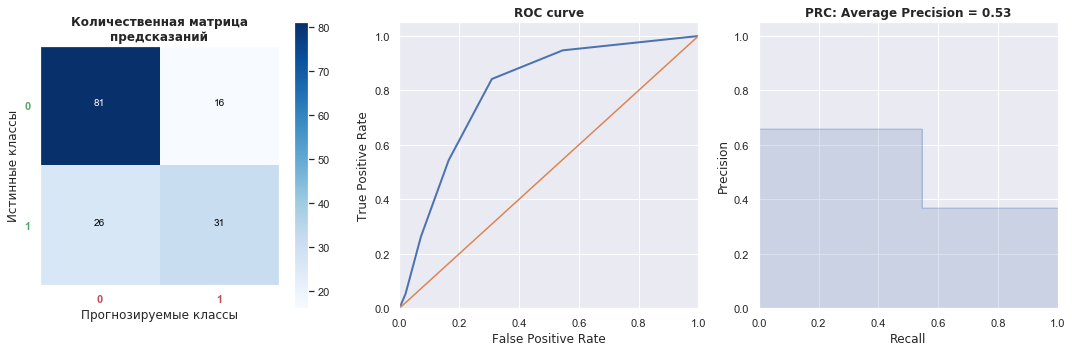


Accuracy: 0.727, AUC-ROC: 0.689


,f1-score,precision,recall,support
0,0.794118,0.757009,0.835052,97.0
1,0.596154,0.659574,0.543860,57.0
micro avg,0.727273,0.727273,0.727273,154.0
macro avg,0.695136,0.708292,0.689456,154.0
weighted avg,0.720845,0.720946,0.727273,154.0



KFold accuracy results: [0.727 0.721 0.771 0.693 0.771] with mean: 0.737


In [50]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier() # применим алгоритм К-ближайших соседей
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

## Decision Trees

**Classification and Regression Trees (CART)** относятся к классу логических методов. Они часто используются в задачах, в которых обьекты имеют категориальные признаки. Прежде всего их используют для многоклассовой классификации, но они приспособленны и для решения задач регрессии (хотя это уже некая экзотика).

Исходно решающие деревья возникли как попытка формализовать тот способ мышления, который используют люди при принятии решений. Например, это хорошо иллюстрируется логикой работы врача, когда он говорит с пациентом и задает один за другим уточняющие вопросы (буквально за 4-5 вопросов он, имея ответы пациента, либо уже ставит диагноз, либо дает ему какие-то советы).

Основная идея решающих деревьев состоит в объединении определенного количества простых решающих правил, благодаря чему итоговый алгоритм является интерпретируемым. Как следует из названия, решающее дерево представляет собой бинарное дерево, где в каждой вершине сопоставлено некоторое правило вида '$j$-й признак имеет значение меньше $b$'. В листьях этого дерева записаны числа-предсказания. Чтобы получить ответ, нужно стартовать из корня и делать переходы либо в левое, либо в правое поддерево в зависимости от того, выполняется правило из текущей вершины или нет.

Одна из особенностей решающих деревьев заключается в том, что они позволяют получать важности всех используемых признаков. Важность признака можно оценить на основе того, как сильно улучшился критерий качества благодаря использованию этого признака в вершинах дерева.

**Преимущества:**

* интерпретируемость
* возможность использования разных типов данных
* не нужно беспокоиться о масштабировании данных
* возможность обхода пропусков в данных

**Недостатки:**

* переобучение
* фрагментация
* неустойчивость к шуму, составу выборки или критерию

**Способы устранения недостатков:**

* редукция (усечение деревьев)
* создание композиций деревьев

Проверка гиперпараметров модели:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


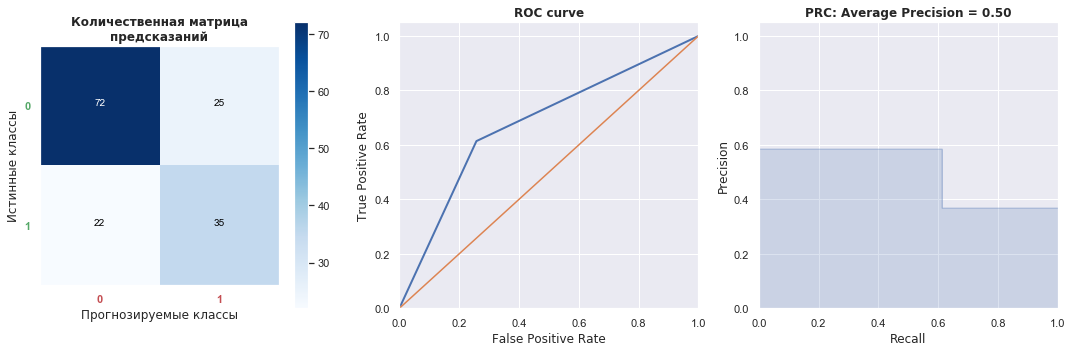


Accuracy: 0.695, AUC-ROC: 0.678


,f1-score,precision,recall,support
0,0.753927,0.765957,0.742268,97.0
1,0.598291,0.583333,0.614035,57.0
micro avg,0.694805,0.694805,0.694805,154.0
macro avg,0.676109,0.674645,0.678152,154.0
weighted avg,0.696321,0.698363,0.694805,154.0



KFold accuracy results: [0.714 0.734 0.732 0.68  0.758] with mean: 0.724


In [51]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # применим алгоритм решающих деревьев
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

## SVM

**Метод опорных векторов** является одним из самых известных алгоритмов машинного обучения, применяемых в основном для решения задач классификации. Функционал, который он оптимизирует, направлен на максимизацию ширины разделяющей полосы между классами. Из теории статистического обучения известно, что эта ширина тесно связана с обобщающей способностью алгоритма, а ее максимизация позволяет бороться с переобучением. При этом он позволяет очень легко перейти к построению нелинейной разделяющей поверхности благодаря ядерному переходу. Также как и логистическая регрессия, SVM допускает многоклассовую классификацию методом **one-vs-all**.

По сути, алгоритм делает предсказания на основе сходства нового объекта с объектами обучающей выборки. При этом, как правило, далеко не все коэффициенты оказываются ненулевыми. Это означает, что классификация делается на основе сходства лишь с частью обучающих объектов. Такие объекты называются опорными.

Одна из причин популярности линейных методов заключается в том, что они хорошо работают на разреженных данных. Так называются выборки с большим количеством признаков, где на каждом объекте большинство признаков равны нулю. Разреженные данные возникают, например, при работе с текстами.

Стоит также заметить, что разница между SVM и логистической регрессией с L2-регуляризацией состоит только в том, что в SMV используется кусочно-постоянная функция, а в логистической регрессии – логарифмическая

**Преимущества:**

* сводится к задаче выпуклого квадратичного программирования, которая имеет единственное решение 
* выделение множества опорных объектов как побочный результат
* имеются эффективные численные методы для решения задачи
* изящное обобщение на нелинейные классификаторы

**Недостатки:**

* опорными объектами могут становиться выбросы
* нет отбора признаков в исходном пространстве
* приходится подбирать константу $C$

**Способы устранения недостатков:**

* поиск и исключение выбросов из выборки
* заданным параметром $C = 100000$ можно убедиться, что SVM работает с выборкой как с линейно разделимой. При более низких значениях параметра алгоритм будет настраиваться с учетом слагаемого в функционале, штрафующего за маленькие отступы, из-за чего результат может не совпасть с решением классической задачи SVM для линейно разделимой выборки

Проверка гиперпараметров модели:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


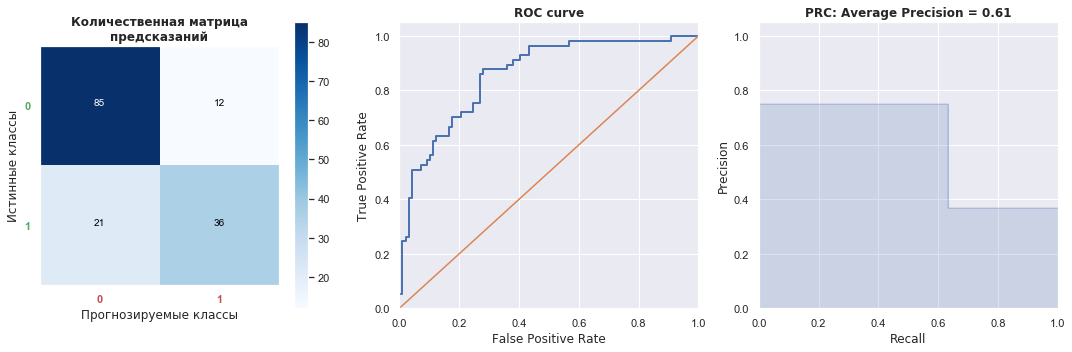


Accuracy: 0.786, AUC-ROC: 0.754


,f1-score,precision,recall,support
0,0.837438,0.801887,0.876289,97.0
1,0.685714,0.750000,0.631579,57.0
micro avg,0.785714,0.785714,0.785714,154.0
macro avg,0.761576,0.775943,0.753934,154.0
weighted avg,0.781281,0.782682,0.785714,154.0



KFold accuracy results: [0.786 0.753 0.797 0.699 0.778] with mean: 0.763


In [52]:
from sklearn.svm import SVC
 
model = SVC(probability=True) # применим алгоритм опорных векторов
model.fit(Xcs_train, yc_train) # запустим тренировку на стандартизированных данных
print('Проверка гиперпараметров модели:\n', model)

clf_inf(model, Xcs_test, yc_test) # изобразим графически информацию о работе

cross_validation(model, Xcs, yc, 'accuracy') # запустим тренировку на кросс-валидации

# Semi-Supervised Lerning

**Частичное обучение** – один из методов машинного обучения, использующий при обучении как размеченные, так и неразмеченные данные. Обычно **используется небольшое количество размеченных и значительный объём неразмеченных данных**. Частичное обучение является компромисом между обучением без учителя (без каких-либо размеченных обучающих данных) и обучением с учителем (с полностью размеченным набором обучения).

Было замечено, что неразмеченные данные, будучи использованными совместно с небольшим количеством размеченных данных, могут обеспечить значительный прирост качества обучения. Под качеством обучения подразумевается некий функционал качества как, например, среднеквадратичная ошибка. Сбор размеченных данных для задачи обучения зачастую требует, чтобы квалифицированный эксперт вручную классифицировал объекты обучения. Затраты, связанные с процессом разметки, могут сделать построение полностью размеченного набора прецедентов невозможным, в то время как сбор неразмеченных данных сравнительно недорог. В подобных ситуациях ценность частичного обучения сложно переоценить.

Примером частичного обучения может послужить сообучение, когда два или более обучаемых алгоритма используют один и тот же набор данных, но каждый из них при обучении использует различные (в идеале некоррелированные) наборы признаков объектов.

Таким образом, задача SSL занимает промежуточное положение между классификацией и кластеризацией, но не сводится к ним. Простые методы-обертки требуют многократного обучения, что вычислительно неэффективно. Методы кластеризации легко адаптируются к SSL путем введения ограничений (**constrained clustering**), но, как правило, вычислительно трудоемки. Методы классификации адаптируются сложнее, но приводят к более эффективному частичному обучению.

# Optimization

Одним из самых сложных этапов в построении действительно эффективных алгоритмов является выбор правильных гиперпараметров. Обычно, это легче дается с опытом, но так или иначе приходится делать перебор. К счастью, в Scikit-Learn уже есть немало реализованных для этого функций.

У моделей есть много гиперпараметров, которые можно изменять, и от этих гиперпараметров существенно зависит качество модели. Найти наилучшие можно с помощью класса **GridSearchCV**, который осуществляет поиск (**search**) по сетке (**grid**) и вычисляет качество модели с помощью кросс-валидации (**CV**).

Для примера посмотрим на подбор параметра регуляризации, в котором мы по очереди перебираем несколько значений:

In [53]:
from sklearn.model_selection import GridSearchCV

model = Ridge() # применим алгоритм гребневой регрессии
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0]) # подготовим массив альфа-значений для теста

# запустим поиск оптимальных гиперпараметров, перебирая альфа-значения
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(Xrs, yrs) # запустим тренировку на ВСЕХ стандартизированных данных

print('Проверка гиперпараметров модели:\n', grid)
print('\nНаилучшее найденное альфа-значение:', grid.best_estimator_.alpha)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xrs, yrs).round(3))

Проверка гиперпараметров модели:
 GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Наилучшее найденное альфа-значение: 1.0

Наилучшее значение правильности на перекрестной проверке: 0.789

Наилучшее значение правильности на тесте (Accuracy): 0.812


Иногда более эффективным оказывается много раз случайно выбрать параметр из данного отрезка, померить качество алгоритма при данном параметре и выбрать тем самым лучший:

In [54]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

model = Ridge() # применим алгоритм гребневой регрессии
param_grid = {'alpha': sp_rand()} # зададим равномерное распределение для получения выборки альфа-параметров

# запустим поиск оптимальных гиперпараметров, перебирая случайные альфа-значения
rgrid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rgrid.fit(Xrs, yrs) # запустим тренировку на ВСЕХ стандартизированных данных

print('Проверка гиперпараметров модели:\n', rgrid)
print('\nНаилучшее найденное альфа-значение:', rgrid.best_estimator_.alpha)
print('\nНаилучшее значение правильности на перекрестной проверке:', rgrid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', rgrid.score(Xrs, yrs).round(3))

Проверка гиперпараметров модели:
 RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002545C00CAC8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Наилучшее найденное альфа-значение: 0.9967207283316234

Наилучшее значение правильности на перекрестной проверке: 0.789

Наилучшее значение правильности на тесте (Accuracy): 0.812


У логистической регрессии, например, можно поменять параметры 'C' и 'penalty' (смыслы всех гиперпараметров есть в документациях). Сам поиск оптимальных параметров может занять длительное время.


Найденные наилучшие параметры модели:
 {'C': 1, 'penalty': 'l1'}

Наилучшее значение правильности на перекрестной проверке: 0.771

Наилучшее значение правильности на тесте (Accuracy): 0.782


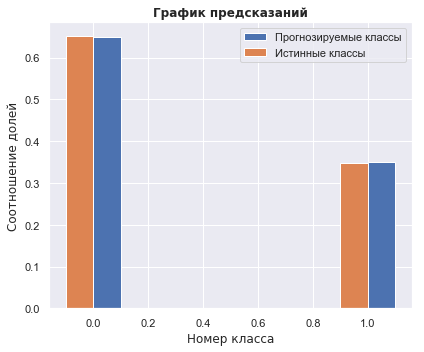

[0.65 0.35]


In [55]:
model = LogisticRegression() # применим алгоритм логистической регрессии
param_grid = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2'],
}

# зададим поиск, который будет перебирать все возможные комбинации значений словаря param_grid
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(Xcs, yc) # запустим тренировку на ВСЕХ стандартизированных данных

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs, yc).round(3))

# вычислим вероятности принадлежности к классам
pred_prob = grid.predict_proba(Xcs)
bar_pred_prob(pred_prob, yc)

Пример подбора параметров для K-NN:


Найденные наилучшие параметры модели:
 {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}

Наилучшее значение правильности на перекрестной проверке: 0.759

Наилучшее значение правильности на тесте (Accuracy): 1.0


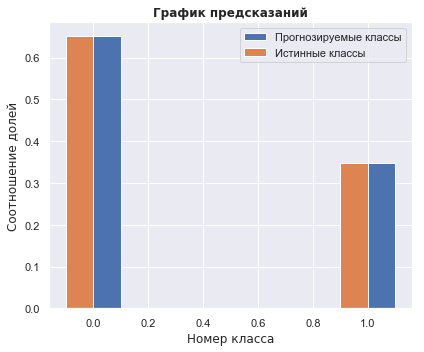

[0.65 0.35]


In [56]:
model = KNeighborsClassifier()
param_grid = {
    'weights': ['uniform', 'distance'], 
    'n_neighbors': np.arange(1, 11), 
    'metric': ['manhattan', 'euclidean']
}

# зададим поиск, который будет перебирать все возможные комбинации значений словаря param_grid
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(Xcs, yc) # запустим тренировку на ВСЕХ стандартизированных данных

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs, yc).round(3))

# используя найденное оптимальное число соседей, вычислим вероятности принадлежности к классам
pred_prob = grid.predict_proba(Xcs)
bar_pred_prob(pred_prob, yc)

Стоит заметить, что мы передавали в GridSearchCV всю выборку, а не только её обучающую часть. Поиск всё равно использует кросс-валидацию, однако порой от выборки всё же отделяют обучающую часть, так как гиперпараметры в процессе поиска могли переобучиться под выборку.


Найденные наилучшие параметры модели:
 {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}

Наилучшее значение правильности на перекрестной проверке: 0.739

Наилучшее значение правильности на тесте (Accuracy): 0.766


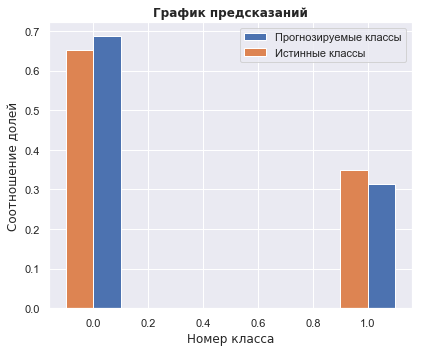

[0.69 0.31]


In [57]:
model = KNeighborsClassifier()
param_grid = {
    'weights': ['uniform', 'distance'], 
    'n_neighbors': np.arange(1, 11), 
    'metric': ['manhattan', 'euclidean']
}

# зададим поиск, который будет перебирать все возможные комбинации значений словаря param_grid
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(Xcs_train, yc_train) # запустим тренировку на обучающей выборке

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs_test, yc_test).round(3))

# используя найденное оптимальное число соседей, вычислим вероятности принадлежности к классам
pred_prob = grid.predict_proba(Xcs)
bar_pred_prob(pred_prob, yc)

# Ensemble

> https://vas3k.ru/blog/machine_learning/

Помимо алгоритмов классификации и регрессии, в Scikit-Learn имеется большое количество и более сложных алгоритмов, в частности техники построения композиций алгоритмов – **ансамбли**: **Stacking**, **Bagging** и **Boosting**. Если лучшая модель уже найдена и повысить точность модели больше не получается – в таком случае нужно применить ансамбли. Сегодня ансамблевые методы дают самые точные результаты и используются всеми крупными компаниями в **Production**.

При всей их эффективности, идея до издевательства проста. Оказывается, если взять несколько не очень эффективных методов обучения и обучить исправлять ошибки друг друга, качество такой системы будет сильно выше, чем каждого из методов по отдельности. Причём даже лучше, когда взятые алгоритмы максимально нестабильны и сильно плавают от входных данных. Поэтому чаще берут регрессию и решающие деревья, которым достаточно одной сильной аномалии в данных, чтобы поехала вся модель. А вот Байеса и К-ближайших не берут никогда – они хоть и простые, но очень стабильные.

## Stacking (Blending)

**Обучаем несколько разных алгоритмов и передаём их результаты на вход последнему, который принимает итоговое решение**. Ключевое слово – разных алгоритмов, ведь один и тот же алгоритм, обученный на одних и тех же данных не имеет смысла. На практике в качестве решающего алгоритма чаще берут регрессию.

Сам по себе данный метод применяется редко, потому что два других обычно точнее (но и их можно обернуть в стекинг, чтобы попытаться усилить действие алгоритмов).

## Bagging (Bootstrap AGGregatING)

**Обучаем один алгоритм много раз на случайных выборках из исходных данных, а в самом конце усредняем ответы**. Данные в случайных выборках могут повторяться. То есть из набора 1-2-3 мы можем делать выборки 2-2-3, 1-2-2, 3-1-2 и так пока не надоест. На них мы обучаем один и тот же алгоритм несколько раз, а в конце вычисляем ответ простым голосованием.

Самый популярный пример – алгоритм **Random Forest**. Это один из самых сильных методов машинного обучения. Он основан на бэггинге как способе построения композиций классификаторов, при котором классификаторы обучаются независимо друг от друга. Так, камера на телефоне, определяющая лица людей в кадре желтыми прямоугольниками – скорее всего использует именно этот алгоритм. Нейросеть, к примеру, слишком медлительна в реальном времени, а беггинг идеален, ведь он может считать свои деревья параллельно на всех шейдерах видеокарты.

Дикая способность параллелиться даёт беггингу преимущество даже над третьим методом, который работает точнее, но только в один поток.

### Random Forest

**Случайный лес** – это специальный случай бэггинга, когда в качестве базового семейства **используются решающие деревья**, при этом, в отличие от обычных способов построения решающих деревьев, здесь **не используется усечение** (**pruning**).

Вообще, метод **настроен на то, чтобы построить композицию как можно быстрее, чтобы можно было строить композиции по большим выборкам данных и в реальном времени**. Построение дерева тоже производится весьма специфическим образом. Когда выбирается признак для каждого внутреннего узла в этом решающем дереве, оно выбирается не из всего множества $n$ признаков, а из какого-то случайного подмножества, состоящего из $k$ признаков. Причем, **если дерево строится для классификаций, то рекомендуется брать $k$ равным корню квадратному из $n$, а если для регрессии – $\dfrac{n}{3}$**. Это эмпирические рекомендации. Оказывается, что если таким образом строить бэггинг над решающими деревьями, мы получим большое количество решающих деревьев, а их простое голосование как раз и будет называться случайным лесом. Прогнозы, выданные деревьями, объединяются в один ответ путем усреднения.

Оказалось, что этот алгоритм чрезвычайно эффективен, он очень быстро обучается и очень хорошо решает практические задачи. Как ни странно, несмотря на то, что столько было внесено случайности в процесс построения решающего леса – простое голосование делает из этих неточных, не очень хорошо построенных деревьев очень хороший агрегированный алгоритм классификации.

Особенность случайного леса заключается в том, что **он не переобучается по мере увеличения количества деревьев в композиции**. Это достигается за счет того, что **деревья не зависят друг от друга, и поэтому добавление нового дерева в композицию не усложняет модель, а лишь понижает уровень шума в прогнозах**.

Как бы то ни было, при решении практических задач случайный лес обычно немного уступает другому композиционному методу, который называется градиентный бустинг.


Найденные наилучшие параметры модели:
 {'max_depth': 35, 'n_estimators': 300}

Наилучшее значение правильности на перекрестной проверке: 0.754

Наилучшее значение правильности на тесте (Accuracy): 0.792


'[AUC-ROC] train: 1.00, [AUC-ROC] test: 0.849'

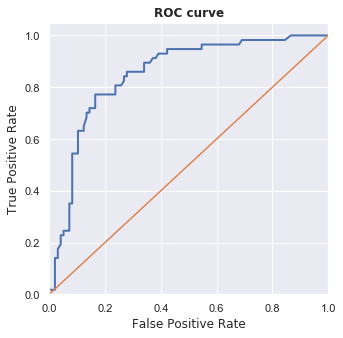

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

param_grid = {
    'n_estimators': np.array([200, 300, 400]), 
    'max_depth': np.array([15, 25, 35])
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(Xcs_train, yc_train)

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs_test, yc_test).round(3))

pylab.figure(figsize=(5, 5))
roc_plot(grid, Xcs_test, yc_test)
auc(grid, yc_train, Xcs_train, yc_test, Xcs_test)

## Boosting

**Обучаем алгоритмы последовательно, каждый следующий уделяет особое внимание тем случаям, на которых ошибся предыдущий**. Как и в беггинге, мы делаем выборки из исходных данных, но теперь не совсем случайно. В каждую новую выборку мы берём часть тех данных, на которых предыдущий алгоритм отработал неправильно. То есть как бы доучиваем новый алгоритм на ошибках предыдущего.

Бустинг – это ещё один способ построения композиций в машинном обучении. И он отличается от бэггинга сразу по нескольким направлениям, обобщая его. Во-первых, **он одинаково применим и к задачам регрессии, и к задачам классификации, то есть он будет допускать произвольные функции потерь**. Далее **он использует взвешенное голосование, где каждый базовый алгоритм получает свой весовой коэффициент** вместо простого в случае бэггинга. Однако, оба метода объединяет то, что они являются методами-обёртками, то есть они эксплуатируют уже готовый метод обучения базовых алгоритмов.

Плюсы метода – **неистовая точность классификации**. Минусы уже названы – **не параллелится**. Однако, всё равно работает **быстрее нейросетей**. И ещё важно отметить, что этот метод появился после того, как были предложены многие разные разновидности бустингов – очень много разных эвристик. А метод градиентного бустинга их всех объединил, и стало понятно, что можно использовать разные функции потерь, можно использовать разные способы приближения градиента и получать разновидности тех бустингов, которые были известны до этого. То есть градиентный бустинг – это такое **суперобобщение многих других известных алгоритмов**.

Градиентный бустинг хорош тем, что он допускает в качестве базовых алгоритмов не только классификаторы, которые возвращают ± 1, а это может быть произвольное пространство оценок, агрегирование которых, как правило, более успешно, чем агрегирование конечных ответов ± единиц. Градиентный бустинг поэтому подходит и для регрессии, и для классификации, и для ранжирования и многих других задач машинного обучения. Важно отметить, что в середине 90-х годов был огромный бум исследований бустинга, связанный с тем, что полной неожиданностью оказалась его высокая обобщающая способность. Оказалось, что даже с ростом сложности композиций и увеличением числа базовых алгоритмов в нем бустинг практически не переобучается. Переобучение может наступать, но после сотен или даже тысяч базовых алгоритмов. И стоит отметить, что, наверное, самый часто используемый вариант градиентного бустинга – это использование решающих деревьев в качестве базовых алгоритмов.

Реальный пример работы бустинга – ранжирование результатов поисковика Яндекса. Яндекс сейчас весь на бустинге (в частности, технология MatrixNet – градиентный бустинг над так называемыми «небрежными» решающими деревьями).  
Сегодня, кроме классического **Gradient Boosting**, есть три популярных метода бустинга: **CatBoost**, **LightGBM** и **XGBoost**.  
**Статья про их отличия:** https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

### Gradient Boosting


Найденные наилучшие параметры модели:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}

Наилучшее значение правильности на перекрестной проверке: 0.741

Наилучшее значение правильности на тесте (Accuracy): 0.786


'[AUC-ROC] train: 1.00, [AUC-ROC] test: 0.852'

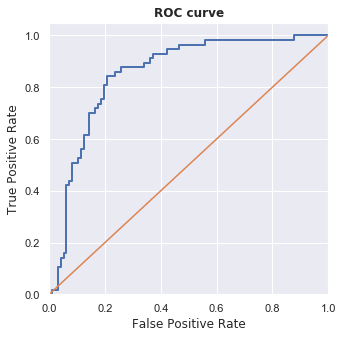

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(verbose=0)
param_grid = {
    "learning_rate": [0.05, 0.1, 0.15],
    "n_estimators": [200],
    "max_depth": [5, 10, 30]
}

grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
grid.fit(Xcs_train, yc_train)

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs_test, yc_test).round(3))

pylab.figure(figsize=(5, 5))
roc_plot(grid, Xcs_test, yc_test)
auc(grid, yc_train, Xcs_train, yc_test, Xcs_test)

### XGBoost


Найденные наилучшие параметры модели:
 {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}

Наилучшее значение правильности на перекрестной проверке: 0.75

Наилучшее значение правильности на тесте (Accuracy): 0.792


'[AUC-ROC] train: 1.00, [AUC-ROC] test: 0.845'

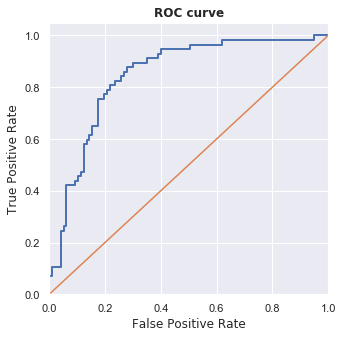

In [60]:
import xgboost as xgb

model = xgb.XGBClassifier(silent=True)
param_grid = {
    "learning_rate": [0.05, 0.1, 0.15],
    "n_estimators": [200],
    "max_depth": [5, 10, 30],
    "min_child_weight": [1, 3, 5]
}

grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
grid.fit(Xcs_train, yc_train)

print('\nНайденные наилучшие параметры модели:\n', grid.best_params_)
print('\nНаилучшее значение правильности на перекрестной проверке:', grid.best_score_.round(3))
print('\nНаилучшее значение правильности на тесте (Accuracy):', grid.score(Xcs_test, yc_test).round(3))

pylab.figure(figsize=(5, 5))
roc_plot(grid, Xcs_test, yc_test)
auc(grid, yc_train, Xcs_train, yc_test, Xcs_test)

### CatBoost


Accuracy: 0.779


'[AUC-ROC] train: 1.00, [AUC-ROC] test: 0.849'

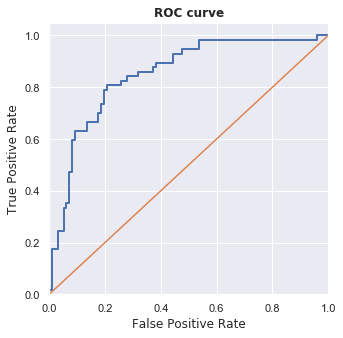

In [61]:
import catboost as cb

model = cb.CatBoostClassifier(eval_metric="AUC", one_hot_max_size=16, 
                            depth=10, iterations=500, l2_leaf_reg=9, learning_rate=0.15, silent=True)

model.fit(Xcs_train, yc_train)

expected = yc_test
predicted = model.predict(Xcs_test)

print('\nAccuracy:', metrics.accuracy_score(expected, predicted).round(3))

pylab.figure(figsize=(5, 5))
roc_plot(model, Xcs_test, yc_test)
auc(model, yc_train, Xcs_train, yc_test, Xcs_test)

### LightGBM

In [62]:
import lightgbm as lgb

lgb_data = lgb.Dataset(Xcs_train, label=yc_train)
lgb_params = {
    "max_depth": 50, 
    "learning_rate" : 0.1, 
    "num_leaves": 900,  
    "n_estimators": 300
}

model = lgb.train(lgb_params, lgb_data)

auc_lgbm(model, yc_train, Xcs_train, yc_test, Xcs_test)

'[AUC-ROC] train: 1.00, [AUC-ROC] test: 0.804'